#  (loss = :mrl, opt = :adagrad, agg = :max, constr = :nneg)

In [1]:
import json
import pprint
import pandas as pd
import numpy as np 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import DictVectorizer
import warnings
warnings.filterwarnings('ignore')

In [2]:
f = open('news.json', 'r')
data = f.readlines()[:1000000]

In [3]:
data = [json.loads(i) for i in data]

In [4]:
data = [{'title' : i['title'], 'descr' : i['descr']} for i in data]

In [5]:
news = pd.DataFrame(data)

In [7]:
import re 
import nltk  
nltk.download('stopwords')  
import pickle  
from nltk.corpus import stopwords 
from nltk import PorterStemmer

import re 
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/anastasiapopova/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
def preprocess_text(document):
    document = re.sub(r'\W', ' ',  document)
    document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)
    document = re.sub(r'\^[a-zA-Z]\s+', ' ', document) 
    document = re.sub(r'\s+', ' ', document, flags=re.I)
    document = document.lower()
    document = document.split()
    document = [lemmatizer.lemmatize(word) for word in document]
    return ' '.join([i for i in document if len(i) > 2])

In [9]:
news.title = news.title.apply(lambda x: preprocess_text(x))
news.descr = news.descr.apply(lambda x: preprocess_text(x))
news.head()

,descr,title
0,следователи скопинского мсо рязанской области ...,рязанской колонии заключенный ударил сотрудник...
1,история российской федерации закончится распад...,работа такая политолог заявлениях украине про ...
2,москва фев риа новости госкорпорация роскосмос...,роскосмос начал сбор анонимных жалоб нарушения...
3,вашингтон февраля синьхуа возвращение культурн...,срочно возвращение культурных ценностей кнр ст...
4,москва февраля тасс лекцию знаменитой московск...,лекция кондитерской династии абрикосовых пройд...


In [10]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

vectorizer = CountVectorizer(max_df=0.5, min_df=10, stop_words=stopwords.words('russian'))
X = vectorizer.fit_transform(news.descr)
y = vectorizer.transform(news.title)
features = vectorizer.get_feature_names()
word2num = {i:indx for indx, i in enumerate(features)} 
num2word = {indx:i for indx, i in enumerate(features)} 

In [11]:
X1, y1 = X, y

# def tokenize_(s):
    a = []
    for s_ in s.split(' '):
        try:
            a.append(word2num[s_])
        except:
            continue
    return a

In [ ]:
X, y = X1, y1

In [32]:
#X = news.descr.apply(lambda x: tokenize_(x))
#y = news.title.apply(lambda x: tokenize_(x))
#X = X.astype(bool).astype(float)
#y = y.astype(bool).astype(float)

In [12]:
X.shape, y.shape

((1000000, 295793), (1000000, 295793))

In [13]:
def backward_hinge(u, v, v_hat, gamma=0.9):
    #print(type(u), type(v), type(v_hat))
    loss = gamma - np.dot(u, v.transpose()) + np.dot(u, v_hat.transpose()) #gamma - np.dot(u, v) + np.dot(u, v_hat)
    #print(type(u), type(v), type(v_hat))
    #print(loss)
    #return loss
    if loss > 0:
        #print('im here')
        return np.array(v_hat - v).flatten(), loss, -u, u
    return None, None, None, None

In [14]:
# https://codereview.stackexchange.com/questions/165371/implementing-adagrad-in-python
def adagrad_update_numpy(w, h, g_t, mask, lr=0.001, epsilon=1e-7):
    #print(g_t)
    h_new = h + g_t * g_t
    h_new = np.where(mask, h_new, h)
    w_new = w - lr * g_t / (np.sqrt(h_new) + epsilon)
    w_new = np.where(mask, w_new, w)
    return w_new, h_new


def update(embedding, idx, max_indicies, delta, nu):
    p = emb.data[:, idx][:, max_indicies]
    print(p)
    g = emp.sigma[:, idx][:, max_indicies]
    emb.sigma[:, idx][:, max_indicies] += delta**2
    emp.data[:, idx][:, max_indicies] -= delta * nu / (np.sqrt(g) + eps)

In [ ]:
a = np.array([1, 2,3])
a * a

In [15]:
def agg(w, x):
    EPS = 1e-8
    #print(type(w), type(x))
    try:
        x = x.todense()
    except:
        pass
    w_filtered_by_words = np.multiply(w, x.transpose()) # .todense() тут выбрали веса по тем словам, которые есть
    res = w_filtered_by_words.max(axis=0) # посчитали эмбэдинг
    # взяли веса, которые равны эмбэдингу и занулили случайные совпадения левых слов
    mask = np.multiply((abs(np.vstack([res for _ in range(w.shape[0])]) - w) < EPS), (w_filtered_by_words > 0.))
    #print(mask.shape)
    #print(type(w), type(x))
    return res, mask # mask show values to update

def get_element(w, X, i):
    return agg(w, X[i]), agg(w, y[i]), agg(w, X[np.random.randint(0, X.shape[0])])

In [16]:
n_embed = 1000
weights = np.random.normal(0., 1., size = (X.shape[1], n_embed))
grad = np.zeros_like(weights)

In [423]:
agg(weights, X[0])[0].shape, agg(weights, X[0])[1].shape # эмбэдинг и маска

((1, 10), (297567, 10))

In [17]:
def recall_at_k(y_pred, k):
    """
    Calculates recall at k ranking metric.
    Args:
        y_predicted: Predictions.
            Each prediction contains ranking score of all ranking candidates for the particular data sample.
            It is supposed that the ranking score for the true candidate goes first in the prediction.
    Returns:
        Recall at k
    """
    num_examples = float(len(y_pred))
    predictions = np.array(y_pred)
    predictions = np.flip(np.argsort(predictions, -1), -1)[:, :k]
    num_correct = 0
    for el in predictions:
        if 0 in el:
            num_correct += 1
    return float(num_correct) / num_examples



In [18]:
from sklearn.metrics.pairwise import cosine_similarity
import heapq

def evaluate(w, x, y, k=1): # капееееец долго
    ''' 
    Calculates recall at k ranking metric on random num_examples. 
    
    '''
    num_correct = 0
    num_examples = y.shape[0]
    #count_to_eval = 100 # x.shape[0]
    ys = np.array([agg(w, i)[0] for i in y]).reshape((y.shape[0], n_embed))
    y_pred = np.array([agg(w, i)[0] for i in x]).reshape((x.shape[0], n_embed))
    distances = cosine_similarity(ys, y_pred)
    #print(distances.shape)
    for i in range(0, distances.shape[0]):
        neig_t = [i[0] for i in heapq.nlargest(k, enumerate(distances[i]), key=lambda x: x[1])]
        if i in  neig_t:
            num_correct += 1
#        neighbours.append(neig_t)
#     for indx in range(num_examples):
#         #indx = np.random.randint(0, count_to_eval)#x.shape[0])
#         pred, mask = agg(w, x[indx])
#         #print(ys.shape, pred.shape)
#         distances = cosine_similarity(ys, pred)
#         #print(distances)
#         neig_t = [i[0] for i in heapq.nlargest(k, enumerate(distances), key=lambda x: x[1])] # вроде, тут индексы топ к
#         #print(neig_t)
#         if indx in  neig_t:
#             num_correct += 1
    #print(num_correct, num_examples)
    return float(num_correct) / num_examples

In [393]:
evaluate(weights, X[:20], y[:20])

0.0

In [26]:
X_train, X_val = X[100:], X[:100]
y_train, y_val = y[100:], y[:100]

In [66]:
# тут я перепутала вывод в принте и вывожу на самом деле топ3 и топ1
# но перезапускать слишком долго =)
from numba import autojit

@autojit
def train():
    n_epoch = 5
    gamma = 0.9
    loss = []
    train_acc_top1 = []
    train_acc_top3 = []
    train_acc_top5 = []
    val_acc_top1 = []
    val_acc_top3 = []
    val_acc_top5 = []
    for epoch in range(n_epoch):
        epoch_loss = []
        train_epoch_acc_top1 = []
        train_epoch_acc_top3 = []
        train_epoch_acc_top5 = []
        val_epoch_acc_top1 = []
        val_epoch_acc_top3 = []
        val_epoch_acc_top5 = []
        for indx in range(X_train.shape[0]): 
            #print(1)
            #true, y, wrong = get_element(weights.copy(), X.copy(), indx) # не знаю, что за магия, но тут портятся типы
            x_true, mask_true = agg(weights, X_train[indx]) #true
            y_true, y_mask = agg(weights, y_train[indx]) # y
            x_wrong, mask_wrong = agg(weights, X_train[np.random.randint(0, X_train.shape[0])]) #wrong
            #print(x_true.shape, mask_true.shape)
            #print(y_true.shape)
            #print(x_wrong.shape, mask_wrong.shape)
            #print('-----------------------')
            delta, loss_, _u, u = backward_hinge(y_true, x_true, x_wrong, gamma) # что-то я не поняла, что мы с этим лоссом делаем
            if delta is not None:
                weights, grad = adagrad_update_numpy(weights, grad, delta, mask_true, lr=0.001, epsilon=1e-7)
                epoch_loss.append(loss_)

            if indx % 100 == 0:
                print('ITER {}'.format(indx))
                loss.append(np.mean(epoch_loss))
                train_epoch_acc_top1.append(0)#evaluate(weights, X_train[:100], y_train[:100], k=1))
                train_epoch_acc_top3.append(evaluate(weights, X_train[:20], y_train[:20], k=3))
                train_epoch_acc_top5.append(evaluate(weights, X_train[:20], y_train[:20], k=5))
                train_acc_top1.append(np.mean(epoch_acc_top1))
                train_acc_top3.append(np.mean(epoch_acc_top3))
                train_acc_top5.append(np.mean(epoch_acc_top5))
                print('Train: R@5 : {:2f}, R@10 : {:2f}'.format(train_acc_top3[-1], train_acc_top1[-1]))
    #             val_epoch_acc_top1.append(0)#evaluate(weights, X_val, y_val, k=1))
    #             val_epoch_acc_top3.append(evaluate(weights, X_val[:20], y_val[:20], k=5))
    #             val_epoch_acc_top5.append(evaluate(weights, X_val[:20], y_val[:20], k=10))
    #             val_acc_top1.append(np.mean(val_epoch_acc_top1))
    #             val_acc_top3.append(np.mean(val_epoch_acc_top3))
    #             val_acc_top5.append(np.mean(val_epoch_acc_top5))
    #             print('Val: R@5 : {:2f}, R@10 : {:2f}'.format(val_acc_top3[-1], val_acc_top5[-1]))

ITER 0
Train: R@5 : 0.000969, R@10 : 0.000580
ITER 100
Train: R@5 : 0.189207, R@10 : 0.132412
ITER 200
Train: R@5 : 0.208876, R@10 : 0.151940
ITER 300
Train: R@5 : 0.226486, R@10 : 0.165594
ITER 400
Train: R@5 : 0.246445, R@10 : 0.167864
ITER 500
Train: R@5 : 0.244515, R@10 : 0.173565
ITER 600
Train: R@5 : 0.251952, R@10 : 0.187501
ITER 700
Train: R@5 : 0.267028, R@10 : 0.188100
ITER 800
Train: R@5 : 0.264468, R@10 : 0.184477
ITER 900
Train: R@5 : 0.268829, R@10 : 0.189703
ITER 1000
Train: R@5 : 0.271563, R@10 : 0.202401
ITER 1100
Train: R@5 : 0.277914, R@10 : 0.200302
ITER 1200
Train: R@5 : 0.285790, R@10 : 0.201871
ITER 1300
Train: R@5 : 0.287277, R@10 : 0.204481
ITER 1400
Train: R@5 : 0.293479, R@10 : 0.207064
ITER 1500
Train: R@5 : 0.294409, R@10 : 0.208489
ITER 1600
Train: R@5 : 0.292992, R@10 : 0.209787
ITER 1700
Train: R@5 : 0.292099, R@10 : 0.213853
ITER 1800
Train: R@5 : 0.300435, R@10 : 0.216182
ITER 1900
Train: R@5 : 0.299333, R@10 : 0.216613
ITER 2000
Train: R@5 : 0.306097,

Train: R@5 : 0.406560, R@10 : 0.293974
ITER 28000
Train: R@5 : 0.412533, R@10 : 0.290236
ITER 28100
Train: R@5 : 0.409349, R@10 : 0.295833
ITER 28200
Train: R@5 : 0.413661, R@10 : 0.292903
ITER 28300
Train: R@5 : 0.407484, R@10 : 0.293576
ITER 28400
Train: R@5 : 0.416706, R@10 : 0.294365
ITER 28500
Train: R@5 : 0.413805, R@10 : 0.296065
ITER 28600
Train: R@5 : 0.415790, R@10 : 0.290281
ITER 28700
Train: R@5 : 0.412901, R@10 : 0.291326
ITER 28800
Train: R@5 : 0.410312, R@10 : 0.289233
ITER 28900
Train: R@5 : 0.413477, R@10 : 0.298271
ITER 29000
Train: R@5 : 0.414666, R@10 : 0.296889
ITER 29100
Train: R@5 : 0.407156, R@10 : 0.296176
ITER 29200
Train: R@5 : 0.405246, R@10 : 0.290862
ITER 29300
Train: R@5 : 0.407512, R@10 : 0.292295
ITER 29400
Train: R@5 : 0.405620, R@10 : 0.292594
ITER 29500
Train: R@5 : 0.406367, R@10 : 0.291949
ITER 29600
Train: R@5 : 0.414746, R@10 : 0.294729
ITER 29700
Train: R@5 : 0.420082, R@10 : 0.293868
ITER 29800
Train: R@5 : 0.411969, R@10 : 0.294381
ITER 29900


Train: R@5 : 0.462222, R@10 : 0.327674
ITER 90700
Train: R@5 : 0.456082, R@10 : 0.326082
ITER 90800
Train: R@5 : 0.462421, R@10 : 0.324297
ITER 90900
Train: R@5 : 0.457696, R@10 : 0.324294
ITER 91000
Train: R@5 : 0.453514, R@10 : 0.324813
ITER 91100
Train: R@5 : 0.450882, R@10 : 0.329061
ITER 91200
Train: R@5 : 0.457963, R@10 : 0.327003
ITER 91300
Train: R@5 : 0.452474, R@10 : 0.330590
ITER 91400
Train: R@5 : 0.454058, R@10 : 0.325671
ITER 91500
Train: R@5 : 0.461748, R@10 : 0.328375
ITER 91600
Train: R@5 : 0.452507, R@10 : 0.328360
ITER 91700
Train: R@5 : 0.458390, R@10 : 0.322031
ITER 91800
Train: R@5 : 0.456193, R@10 : 0.322889
ITER 91900
Train: R@5 : 0.459762, R@10 : 0.329468
ITER 92000
Train: R@5 : 0.459256, R@10 : 0.327767
ITER 92100
Train: R@5 : 0.459515, R@10 : 0.324565
ITER 92200
Train: R@5 : 0.456827, R@10 : 0.328179
ITER 92300
Train: R@5 : 0.461321, R@10 : 0.327462
ITER 92400
Train: R@5 : 0.453307, R@10 : 0.326257
ITER 92500
Train: R@5 : 0.459028, R@10 : 0.324501
ITER 92600


ITER 165200
Train: R@5 : 0.480723, R@10 : 0.345938
ITER 165300
Train: R@5 : 0.483599, R@10 : 0.338337
ITER 165400
Train: R@5 : 0.484082, R@10 : 0.341346
ITER 165500
Train: R@5 : 0.479059, R@10 : 0.345033
ITER 165600
Train: R@5 : 0.479220, R@10 : 0.341317
ITER 165700
Train: R@5 : 0.479944, R@10 : 0.344370
ITER 165800
Train: R@5 : 0.489868, R@10 : 0.339708
ITER 165900
Train: R@5 : 0.479677, R@10 : 0.342734
ITER 166000
Train: R@5 : 0.476467, R@10 : 0.341870
ITER 166100
Train: R@5 : 0.479847, R@10 : 0.340814
ITER 166200
Train: R@5 : 0.487064, R@10 : 0.339989
ITER 166300
Train: R@5 : 0.480903, R@10 : 0.341985
ITER 166400
Train: R@5 : 0.489239, R@10 : 0.348106
ITER 166500
Train: R@5 : 0.477753, R@10 : 0.340158
ITER 166600
Train: R@5 : 0.478815, R@10 : 0.347982
ITER 166700
Train: R@5 : 0.486486, R@10 : 0.350035
ITER 166800
Train: R@5 : 0.483724, R@10 : 0.345126
ITER 166900
Train: R@5 : 0.483967, R@10 : 0.342922
ITER 167000
Train: R@5 : 0.485487, R@10 : 0.344970
ITER 167100
Train: R@5 : 0.4789

Train: R@5 : 0.497030, R@10 : 0.351858
ITER 239700
Train: R@5 : 0.487944, R@10 : 0.355931
ITER 239800
Train: R@5 : 0.489588, R@10 : 0.356557
ITER 239900
Train: R@5 : 0.497095, R@10 : 0.354510
ITER 240000
Train: R@5 : 0.493622, R@10 : 0.353287
ITER 240100
Train: R@5 : 0.495318, R@10 : 0.351494
ITER 240200
Train: R@5 : 0.502992, R@10 : 0.354161
ITER 240300
Train: R@5 : 0.494363, R@10 : 0.352038
ITER 240400
Train: R@5 : 0.491597, R@10 : 0.354269
ITER 240500
Train: R@5 : 0.498918, R@10 : 0.352685
ITER 240600
Train: R@5 : 0.500281, R@10 : 0.356990
ITER 240700
Train: R@5 : 0.491926, R@10 : 0.351087
ITER 240800
Train: R@5 : 0.496616, R@10 : 0.351919
ITER 240900
Train: R@5 : 0.500594, R@10 : 0.359210
ITER 241000
Train: R@5 : 0.489700, R@10 : 0.355994
ITER 241100
Train: R@5 : 0.492719, R@10 : 0.355642
ITER 241200
Train: R@5 : 0.496713, R@10 : 0.354787
ITER 241300
Train: R@5 : 0.494151, R@10 : 0.351644
ITER 241400
Train: R@5 : 0.494554, R@10 : 0.349889
ITER 241500
Train: R@5 : 0.498340, R@10 : 0

ITER 312300
Train: R@5 : 0.510170, R@10 : 0.362009
ITER 312400
Train: R@5 : 0.505368, R@10 : 0.358812
ITER 312500
Train: R@5 : 0.515010, R@10 : 0.359914
ITER 312600
Train: R@5 : 0.508627, R@10 : 0.360059
ITER 312700
Train: R@5 : 0.508457, R@10 : 0.359018
ITER 312800
Train: R@5 : 0.508457, R@10 : 0.360113
ITER 312900
Train: R@5 : 0.505956, R@10 : 0.357239
ITER 313000
Train: R@5 : 0.506407, R@10 : 0.359510
ITER 313100
Train: R@5 : 0.504403, R@10 : 0.362476
ITER 313200
Train: R@5 : 0.506383, R@10 : 0.358817
ITER 313300
Train: R@5 : 0.510972, R@10 : 0.364305
ITER 313400
Train: R@5 : 0.505461, R@10 : 0.363392
ITER 313500
Train: R@5 : 0.509702, R@10 : 0.355028
ITER 313600
Train: R@5 : 0.510057, R@10 : 0.358209
ITER 313700
Train: R@5 : 0.502350, R@10 : 0.358501
ITER 313800
Train: R@5 : 0.511631, R@10 : 0.360843
ITER 313900
Train: R@5 : 0.506285, R@10 : 0.364485
ITER 314000
Train: R@5 : 0.503282, R@10 : 0.362384
ITER 314100
Train: R@5 : 0.505332, R@10 : 0.362507
ITER 314200
Train: R@5 : 0.5075

Train: R@5 : 0.514142, R@10 : 0.367682
ITER 373000
Train: R@5 : 0.513078, R@10 : 0.370111
ITER 373100
Train: R@5 : 0.509951, R@10 : 0.361202
ITER 373200
Train: R@5 : 0.505051, R@10 : 0.368651
ITER 373300
Train: R@5 : 0.518321, R@10 : 0.366893
ITER 373400
Train: R@5 : 0.512968, R@10 : 0.366347
ITER 373500
Train: R@5 : 0.510509, R@10 : 0.367662
ITER 373600
Train: R@5 : 0.514564, R@10 : 0.368871
ITER 373700
Train: R@5 : 0.508055, R@10 : 0.365044
ITER 373800
Train: R@5 : 0.512885, R@10 : 0.374022
ITER 373900
Train: R@5 : 0.511391, R@10 : 0.366192
ITER 374000
Train: R@5 : 0.508495, R@10 : 0.367428
ITER 374100
Train: R@5 : 0.511409, R@10 : 0.367574
ITER 374200
Train: R@5 : 0.515448, R@10 : 0.365537
ITER 374300
Train: R@5 : 0.514145, R@10 : 0.365410
ITER 374400
Train: R@5 : 0.510459, R@10 : 0.367132
ITER 374500
Train: R@5 : 0.512091, R@10 : 0.367168
ITER 374600
Train: R@5 : 0.513781, R@10 : 0.362685
ITER 374700
Train: R@5 : 0.507709, R@10 : 0.371083
ITER 374800
Train: R@5 : 0.518711, R@10 : 0

Train: R@5 : 0.521255, R@10 : 0.373658
ITER 427300
Train: R@5 : 0.524285, R@10 : 0.366808
ITER 427400
Train: R@5 : 0.518212, R@10 : 0.374280
ITER 427500
Train: R@5 : 0.514733, R@10 : 0.377805
ITER 427600
Train: R@5 : 0.513922, R@10 : 0.369930
ITER 427700
Train: R@5 : 0.511698, R@10 : 0.367797
ITER 427800
Train: R@5 : 0.522721, R@10 : 0.368336
ITER 427900
Train: R@5 : 0.525463, R@10 : 0.370515
ITER 428000
Train: R@5 : 0.510345, R@10 : 0.371805
ITER 428100
Train: R@5 : 0.516296, R@10 : 0.374441
ITER 428200
Train: R@5 : 0.517092, R@10 : 0.369128
ITER 428300
Train: R@5 : 0.515153, R@10 : 0.366863
ITER 428400
Train: R@5 : 0.519103, R@10 : 0.371957
ITER 428500
Train: R@5 : 0.521403, R@10 : 0.373451
ITER 428600
Train: R@5 : 0.517123, R@10 : 0.371539
ITER 428700
Train: R@5 : 0.517739, R@10 : 0.374553
ITER 428800
Train: R@5 : 0.516154, R@10 : 0.368200
ITER 428900
Train: R@5 : 0.518494, R@10 : 0.372929
ITER 429000
Train: R@5 : 0.522974, R@10 : 0.363331
ITER 429100
Train: R@5 : 0.518207, R@10 : 0

ITER 488000
Train: R@5 : 0.516431, R@10 : 0.375135
ITER 488100
Train: R@5 : 0.528164, R@10 : 0.375737
ITER 488200
Train: R@5 : 0.523973, R@10 : 0.370509
ITER 488300
Train: R@5 : 0.521623, R@10 : 0.374626
ITER 488400
Train: R@5 : 0.529948, R@10 : 0.371538
ITER 488500
Train: R@5 : 0.523059, R@10 : 0.376100
ITER 488600
Train: R@5 : 0.530920, R@10 : 0.372657
ITER 488700
Train: R@5 : 0.526193, R@10 : 0.374432
ITER 488800
Train: R@5 : 0.518595, R@10 : 0.375347
ITER 488900
Train: R@5 : 0.520828, R@10 : 0.379140
ITER 489000
Train: R@5 : 0.525587, R@10 : 0.375956
ITER 489100
Train: R@5 : 0.521875, R@10 : 0.371718
ITER 489200
Train: R@5 : 0.524630, R@10 : 0.372499
ITER 489300
Train: R@5 : 0.522745, R@10 : 0.371529
ITER 489400
Train: R@5 : 0.522329, R@10 : 0.375497
ITER 489500
Train: R@5 : 0.522346, R@10 : 0.375989
ITER 489600
Train: R@5 : 0.530407, R@10 : 0.370478
ITER 489700
Train: R@5 : 0.523750, R@10 : 0.369904
ITER 489800
Train: R@5 : 0.525336, R@10 : 0.377599
ITER 489900
Train: R@5 : 0.5194

Train: R@5 : 0.528637, R@10 : 0.371402
ITER 556000
Train: R@5 : 0.531305, R@10 : 0.378306
ITER 556100
Train: R@5 : 0.528381, R@10 : 0.375485
ITER 556200
Train: R@5 : 0.536529, R@10 : 0.381155
ITER 556300
Train: R@5 : 0.523671, R@10 : 0.381797
ITER 556400
Train: R@5 : 0.529848, R@10 : 0.377541
ITER 556500
Train: R@5 : 0.527198, R@10 : 0.375892
ITER 556600
Train: R@5 : 0.531200, R@10 : 0.370869
ITER 556700
Train: R@5 : 0.528968, R@10 : 0.380862
ITER 556800
Train: R@5 : 0.522602, R@10 : 0.379433
ITER 556900
Train: R@5 : 0.534296, R@10 : 0.374757
ITER 557000
Train: R@5 : 0.538434, R@10 : 0.377791
ITER 557100
Train: R@5 : 0.530814, R@10 : 0.378599
ITER 557200
Train: R@5 : 0.521258, R@10 : 0.378176
ITER 557300
Train: R@5 : 0.526323, R@10 : 0.379836
ITER 557400
Train: R@5 : 0.524697, R@10 : 0.377166
ITER 557500
Train: R@5 : 0.529109, R@10 : 0.378164
ITER 557600
Train: R@5 : 0.530100, R@10 : 0.380111
ITER 557700
Train: R@5 : 0.522263, R@10 : 0.380403
ITER 557800
Train: R@5 : 0.525960, R@10 : 0

Train: R@5 : 0.532748, R@10 : 0.378931
ITER 610700
Train: R@5 : 0.534975, R@10 : 0.384356
ITER 610800
Train: R@5 : 0.527329, R@10 : 0.381509
ITER 610900
Train: R@5 : 0.536741, R@10 : 0.378577
ITER 611000
Train: R@5 : 0.534941, R@10 : 0.382180
ITER 611100
Train: R@5 : 0.535368, R@10 : 0.382349
ITER 611200
Train: R@5 : 0.540308, R@10 : 0.381771
ITER 611300
Train: R@5 : 0.524697, R@10 : 0.376918
ITER 611400
Train: R@5 : 0.533081, R@10 : 0.382680
ITER 611500
Train: R@5 : 0.528303, R@10 : 0.378103
ITER 611600
Train: R@5 : 0.535425, R@10 : 0.382404
ITER 611700
Train: R@5 : 0.533297, R@10 : 0.380295
ITER 611800
Train: R@5 : 0.538557, R@10 : 0.381059
ITER 611900
Train: R@5 : 0.536148, R@10 : 0.377393
ITER 612000
Train: R@5 : 0.537840, R@10 : 0.379320
ITER 612100
Train: R@5 : 0.525432, R@10 : 0.382052
ITER 612200
Train: R@5 : 0.534165, R@10 : 0.384188
ITER 612300
Train: R@5 : 0.529194, R@10 : 0.380985
ITER 612400
Train: R@5 : 0.532358, R@10 : 0.378394
ITER 612500
Train: R@5 : 0.532668, R@10 : 0

ITER 662100
Train: R@5 : 0.530049, R@10 : 0.385987
ITER 662200
Train: R@5 : 0.532972, R@10 : 0.386143
ITER 662300
Train: R@5 : 0.529530, R@10 : 0.383404
ITER 662400
Train: R@5 : 0.532177, R@10 : 0.382848
ITER 662500
Train: R@5 : 0.534542, R@10 : 0.385216
ITER 662600
Train: R@5 : 0.538081, R@10 : 0.385893
ITER 662700
Train: R@5 : 0.541084, R@10 : 0.382044
ITER 662800
Train: R@5 : 0.531230, R@10 : 0.389346
ITER 662900
Train: R@5 : 0.527065, R@10 : 0.382354
ITER 663000
Train: R@5 : 0.540636, R@10 : 0.377469
ITER 663100
Train: R@5 : 0.534658, R@10 : 0.386504
ITER 663200
Train: R@5 : 0.536492, R@10 : 0.381026
ITER 663300
Train: R@5 : 0.540090, R@10 : 0.387731
ITER 663400
Train: R@5 : 0.535211, R@10 : 0.384275
ITER 663500
Train: R@5 : 0.535682, R@10 : 0.377451
ITER 663600
Train: R@5 : 0.538094, R@10 : 0.384156
ITER 663700
Train: R@5 : 0.540855, R@10 : 0.385715
ITER 663800
Train: R@5 : 0.540324, R@10 : 0.387617
ITER 663900
Train: R@5 : 0.535563, R@10 : 0.385063
ITER 664000
Train: R@5 : 0.5364

ITER 720700
Train: R@5 : 0.538366, R@10 : 0.391046
ITER 720800
Train: R@5 : 0.539981, R@10 : 0.382652
ITER 720900
Train: R@5 : 0.535198, R@10 : 0.389665
ITER 721000
Train: R@5 : 0.540679, R@10 : 0.387487
ITER 721100
Train: R@5 : 0.544527, R@10 : 0.387985
ITER 721200
Train: R@5 : 0.544951, R@10 : 0.388825
ITER 721300
Train: R@5 : 0.538712, R@10 : 0.386464
ITER 721400
Train: R@5 : 0.547542, R@10 : 0.384400
ITER 721500
Train: R@5 : 0.543386, R@10 : 0.384854
ITER 721600
Train: R@5 : 0.543063, R@10 : 0.381118
ITER 721700
Train: R@5 : 0.535647, R@10 : 0.383808
ITER 721800
Train: R@5 : 0.538492, R@10 : 0.386973
ITER 721900
Train: R@5 : 0.537013, R@10 : 0.385595
ITER 722000
Train: R@5 : 0.545715, R@10 : 0.386326
ITER 722100
Train: R@5 : 0.537000, R@10 : 0.383020
ITER 722200
Train: R@5 : 0.541917, R@10 : 0.386345
ITER 722300
Train: R@5 : 0.538690, R@10 : 0.391590
ITER 722400
Train: R@5 : 0.539904, R@10 : 0.383867
ITER 722500
Train: R@5 : 0.535648, R@10 : 0.383094
ITER 722600
Train: R@5 : 0.5391

ITER 788500
Train: R@5 : 0.550439, R@10 : 0.387272
ITER 788600
Train: R@5 : 0.547764, R@10 : 0.386140
ITER 788700
Train: R@5 : 0.547315, R@10 : 0.386083
ITER 788800
Train: R@5 : 0.543235, R@10 : 0.389605
ITER 788900
Train: R@5 : 0.545860, R@10 : 0.385113
ITER 789000
Train: R@5 : 0.540848, R@10 : 0.391459
ITER 789100
Train: R@5 : 0.549955, R@10 : 0.387063
ITER 789200
Train: R@5 : 0.547327, R@10 : 0.382958
ITER 789300
Train: R@5 : 0.539620, R@10 : 0.392223
ITER 789400
Train: R@5 : 0.540269, R@10 : 0.387662
ITER 789500
Train: R@5 : 0.540304, R@10 : 0.386302
ITER 789600
Train: R@5 : 0.544887, R@10 : 0.389922
ITER 789700
Train: R@5 : 0.539486, R@10 : 0.386074
ITER 789800
Train: R@5 : 0.544316, R@10 : 0.392060
ITER 789900
Train: R@5 : 0.535824, R@10 : 0.386096
ITER 790000
Train: R@5 : 0.543182, R@10 : 0.387881
ITER 790100
Train: R@5 : 0.548835, R@10 : 0.385268
ITER 790200
Train: R@5 : 0.533528, R@10 : 0.391445
ITER 790300
Train: R@5 : 0.537445, R@10 : 0.388914
ITER 790400
Train: R@5 : 0.5395

Train: R@5 : 0.537463, R@10 : 0.392419
ITER 855800
Train: R@5 : 0.552424, R@10 : 0.388777
ITER 855900
Train: R@5 : 0.546298, R@10 : 0.388283
ITER 856000
Train: R@5 : 0.539940, R@10 : 0.386727
ITER 856100
Train: R@5 : 0.548132, R@10 : 0.393202
ITER 856200
Train: R@5 : 0.542668, R@10 : 0.389456
ITER 856300
Train: R@5 : 0.546468, R@10 : 0.389651
ITER 856400
Train: R@5 : 0.544660, R@10 : 0.391146
ITER 856500
Train: R@5 : 0.547502, R@10 : 0.386627
ITER 856600
Train: R@5 : 0.543174, R@10 : 0.392705
ITER 856700
Train: R@5 : 0.547775, R@10 : 0.384949
ITER 856800
Train: R@5 : 0.546777, R@10 : 0.391828
ITER 856900
Train: R@5 : 0.544674, R@10 : 0.390739
ITER 857000
Train: R@5 : 0.545829, R@10 : 0.389485
ITER 857100
Train: R@5 : 0.549049, R@10 : 0.390642
ITER 857200
Train: R@5 : 0.546008, R@10 : 0.386252
ITER 857300
Train: R@5 : 0.543383, R@10 : 0.389022
ITER 857400
Train: R@5 : 0.544371, R@10 : 0.383923
ITER 857500
Train: R@5 : 0.540591, R@10 : 0.391846
ITER 857600
Train: R@5 : 0.543356, R@10 : 0

Train: R@5 : 0.550990, R@10 : 0.389956
ITER 911700
Train: R@5 : 0.554636, R@10 : 0.396450
ITER 911800
Train: R@5 : 0.551635, R@10 : 0.391087
ITER 911900
Train: R@5 : 0.545038, R@10 : 0.388204
ITER 912000
Train: R@5 : 0.551225, R@10 : 0.395188
ITER 912100
Train: R@5 : 0.551917, R@10 : 0.392269
ITER 912200
Train: R@5 : 0.548486, R@10 : 0.392835
ITER 912300
Train: R@5 : 0.554281, R@10 : 0.395216
ITER 912400
Train: R@5 : 0.555742, R@10 : 0.392857
ITER 912500
Train: R@5 : 0.551896, R@10 : 0.390107
ITER 912600
Train: R@5 : 0.543235, R@10 : 0.394373
ITER 912700
Train: R@5 : 0.542971, R@10 : 0.390380
ITER 912800
Train: R@5 : 0.552641, R@10 : 0.389679
ITER 912900
Train: R@5 : 0.546293, R@10 : 0.393118
ITER 913000
Train: R@5 : 0.556017, R@10 : 0.393637
ITER 913100
Train: R@5 : 0.549623, R@10 : 0.387138
ITER 913200
Train: R@5 : 0.551712, R@10 : 0.391199
ITER 913300
Train: R@5 : 0.547137, R@10 : 0.392752
ITER 913400
Train: R@5 : 0.552279, R@10 : 0.395298
ITER 913500
Train: R@5 : 0.559136, R@10 : 0

Train: R@5 : 0.554599, R@10 : 0.390574
ITER 971700
Train: R@5 : 0.553768, R@10 : 0.391397
ITER 971800
Train: R@5 : 0.553529, R@10 : 0.392175
ITER 971900
Train: R@5 : 0.552983, R@10 : 0.395766
ITER 972000
Train: R@5 : 0.550881, R@10 : 0.392720
ITER 972100
Train: R@5 : 0.552125, R@10 : 0.394319
ITER 972200
Train: R@5 : 0.555518, R@10 : 0.389523
ITER 972300
Train: R@5 : 0.545500, R@10 : 0.396713
ITER 972400
Train: R@5 : 0.559554, R@10 : 0.392828
ITER 972500
Train: R@5 : 0.554117, R@10 : 0.394917
ITER 972600
Train: R@5 : 0.552397, R@10 : 0.394461
ITER 972700
Train: R@5 : 0.554236, R@10 : 0.393846
ITER 972800
Train: R@5 : 0.553482, R@10 : 0.391441
ITER 972900
Train: R@5 : 0.550004, R@10 : 0.397968
ITER 973000
Train: R@5 : 0.548053, R@10 : 0.395202
ITER 973100
Train: R@5 : 0.550118, R@10 : 0.398628
ITER 973200
Train: R@5 : 0.546870, R@10 : 0.389521
ITER 973300
Train: R@5 : 0.551827, R@10 : 0.397138
ITER 973400
Train: R@5 : 0.552270, R@10 : 0.394885
ITER 973500
Train: R@5 : 0.544493, R@10 : 0

Train: R@5 : 0.563247, R@10 : 0.393443
ITER 1038800
Train: R@5 : 0.555287, R@10 : 0.393813
ITER 1038900
Train: R@5 : 0.553907, R@10 : 0.394041
ITER 1039000
Train: R@5 : 0.551060, R@10 : 0.399202
ITER 1039100
Train: R@5 : 0.549544, R@10 : 0.394957
ITER 1039200
Train: R@5 : 0.554655, R@10 : 0.397241
ITER 1039300
Train: R@5 : 0.556157, R@10 : 0.393496
ITER 1039400
Train: R@5 : 0.547880, R@10 : 0.391685
ITER 1039500
Train: R@5 : 0.552776, R@10 : 0.398482
ITER 1039600
Train: R@5 : 0.551530, R@10 : 0.394199
ITER 1039700
Train: R@5 : 0.552346, R@10 : 0.397621
ITER 1039800
Train: R@5 : 0.562440, R@10 : 0.396639
ITER 1039900
Train: R@5 : 0.563724, R@10 : 0.397033
ITER 1040000
Train: R@5 : 0.563208, R@10 : 0.392839
ITER 1040100
Train: R@5 : 0.554037, R@10 : 0.398065
ITER 1040200
Train: R@5 : 0.548050, R@10 : 0.393573
ITER 1040300
Train: R@5 : 0.553499, R@10 : 0.396846
ITER 1040400
Train: R@5 : 0.555634, R@10 : 0.398347
ITER 1040500
Train: R@5 : 0.550216, R@10 : 0.393024
ITER 1040600
Train: R@5 :

ITER 1110200
Train: R@5 : 0.557783, R@10 : 0.397298
ITER 1110300
Train: R@5 : 0.562826, R@10 : 0.394291
ITER 1110400
Train: R@5 : 0.553392, R@10 : 0.399525
ITER 1110500
Train: R@5 : 0.555878, R@10 : 0.396248
ITER 1110600
Train: R@5 : 0.551308, R@10 : 0.399475
ITER 1110700
Train: R@5 : 0.556139, R@10 : 0.395840
ITER 1110800
Train: R@5 : 0.557492, R@10 : 0.401326
ITER 1110900
Train: R@5 : 0.562408, R@10 : 0.401255
ITER 1111000
Train: R@5 : 0.557616, R@10 : 0.392592
ITER 1111100
Train: R@5 : 0.558092, R@10 : 0.396152
ITER 1111200
Train: R@5 : 0.568650, R@10 : 0.392985
ITER 1111300
Train: R@5 : 0.554006, R@10 : 0.396669
ITER 1111400
Train: R@5 : 0.559060, R@10 : 0.398291
ITER 1111500
Train: R@5 : 0.553949, R@10 : 0.400717
ITER 1111600
Train: R@5 : 0.559410, R@10 : 0.393526
ITER 1111700
Train: R@5 : 0.549583, R@10 : 0.393964
ITER 1111800
Train: R@5 : 0.559695, R@10 : 0.397925
ITER 1111900
Train: R@5 : 0.557750, R@10 : 0.399952
ITER 1112000
Train: R@5 : 0.557012, R@10 : 0.402834
ITER 1112100

ITER 1162600
Train: R@5 : 0.558570, R@10 : 0.401306
ITER 1162700
Train: R@5 : 0.559390, R@10 : 0.398436
ITER 1162800
Train: R@5 : 0.559142, R@10 : 0.399300
ITER 1162900
Train: R@5 : 0.556481, R@10 : 0.401259
ITER 1163000
Train: R@5 : 0.557178, R@10 : 0.401698
ITER 1163100
Train: R@5 : 0.557336, R@10 : 0.398291
ITER 1163200
Train: R@5 : 0.560799, R@10 : 0.400303
ITER 1163300
Train: R@5 : 0.549044, R@10 : 0.398097
ITER 1163400
Train: R@5 : 0.555865, R@10 : 0.395879
ITER 1163500
Train: R@5 : 0.553443, R@10 : 0.402048
ITER 1163600
Train: R@5 : 0.559803, R@10 : 0.404099
ITER 1163700
Train: R@5 : 0.563841, R@10 : 0.399186
ITER 1163800
Train: R@5 : 0.562136, R@10 : 0.400388
ITER 1163900
Train: R@5 : 0.559233, R@10 : 0.398203
ITER 1164000
Train: R@5 : 0.557430, R@10 : 0.399374
ITER 1164100
Train: R@5 : 0.551647, R@10 : 0.399352
ITER 1164200
Train: R@5 : 0.556063, R@10 : 0.394540
ITER 1164300
Train: R@5 : 0.562697, R@10 : 0.400207
ITER 1164400
Train: R@5 : 0.556565, R@10 : 0.394437
ITER 1164500

Train: R@5 : 0.553839, R@10 : 0.401031
ITER 1223500
Train: R@5 : 0.567927, R@10 : 0.402671
ITER 1223600
Train: R@5 : 0.565408, R@10 : 0.400035
ITER 1223700
Train: R@5 : 0.558152, R@10 : 0.402080
ITER 1223800
Train: R@5 : 0.562983, R@10 : 0.400753
ITER 1223900
Train: R@5 : 0.556078, R@10 : 0.397964
ITER 1224000
Train: R@5 : 0.556690, R@10 : 0.400940
ITER 1224100
Train: R@5 : 0.554391, R@10 : 0.394938
ITER 1224200
Train: R@5 : 0.565218, R@10 : 0.398219
ITER 1224300
Train: R@5 : 0.556312, R@10 : 0.401471
ITER 1224400
Train: R@5 : 0.556938, R@10 : 0.402640
ITER 1224500
Train: R@5 : 0.555638, R@10 : 0.408468
ITER 1224600
Train: R@5 : 0.560030, R@10 : 0.400390
ITER 1224700
Train: R@5 : 0.558397, R@10 : 0.402136
ITER 1224800
Train: R@5 : 0.563329, R@10 : 0.397179
ITER 1224900
Train: R@5 : 0.562280, R@10 : 0.397705
ITER 1225000
Train: R@5 : 0.562303, R@10 : 0.402334
ITER 1225100
Train: R@5 : 0.560404, R@10 : 0.397555
ITER 1225200
Train: R@5 : 0.557196, R@10 : 0.400103
ITER 1225300
Train: R@5 :

Train: R@5 : 0.557251, R@10 : 0.400314
ITER 1288300
Train: R@5 : 0.563835, R@10 : 0.402609
ITER 1288400
Train: R@5 : 0.560055, R@10 : 0.399021
ITER 1288500
Train: R@5 : 0.563328, R@10 : 0.400958
ITER 1288600
Train: R@5 : 0.564072, R@10 : 0.403616
ITER 1288700
Train: R@5 : 0.564199, R@10 : 0.402237
ITER 1288800
Train: R@5 : 0.560922, R@10 : 0.397602
ITER 1288900
Train: R@5 : 0.569561, R@10 : 0.398113
ITER 1289000
Train: R@5 : 0.562621, R@10 : 0.401948
ITER 1289100
Train: R@5 : 0.558309, R@10 : 0.403555
ITER 1289200
Train: R@5 : 0.565280, R@10 : 0.406083
ITER 1289300
Train: R@5 : 0.562118, R@10 : 0.406533
ITER 1289400
Train: R@5 : 0.558838, R@10 : 0.404205
ITER 1289500
Train: R@5 : 0.562952, R@10 : 0.399253
ITER 1289600
Train: R@5 : 0.565770, R@10 : 0.400406
ITER 1289700
Train: R@5 : 0.567259, R@10 : 0.398882
ITER 1289800
Train: R@5 : 0.560640, R@10 : 0.402494
ITER 1289900
Train: R@5 : 0.567772, R@10 : 0.401680
ITER 1290000
Train: R@5 : 0.567998, R@10 : 0.404070
ITER 1290100
Train: R@5 :

Train: R@5 : 0.562435, R@10 : 0.399293
ITER 1358400
Train: R@5 : 0.570524, R@10 : 0.403607
ITER 1358500
Train: R@5 : 0.570558, R@10 : 0.398882
ITER 1358600
Train: R@5 : 0.562192, R@10 : 0.404819
ITER 1358700
Train: R@5 : 0.562982, R@10 : 0.407610
ITER 1358800
Train: R@5 : 0.565791, R@10 : 0.401824
ITER 1358900
Train: R@5 : 0.568349, R@10 : 0.401759
ITER 1359000
Train: R@5 : 0.567340, R@10 : 0.406898
ITER 1359100
Train: R@5 : 0.570737, R@10 : 0.399369
ITER 1359200
Train: R@5 : 0.559598, R@10 : 0.403815
ITER 1359300
Train: R@5 : 0.571127, R@10 : 0.405594
ITER 1359400
Train: R@5 : 0.566792, R@10 : 0.407811
ITER 1359500
Train: R@5 : 0.556824, R@10 : 0.406159
ITER 1359600
Train: R@5 : 0.556027, R@10 : 0.409021
ITER 1359700
Train: R@5 : 0.566389, R@10 : 0.407272
ITER 1359800
Train: R@5 : 0.566600, R@10 : 0.402418
ITER 1359900
Train: R@5 : 0.571855, R@10 : 0.404469
ITER 1360000
Train: R@5 : 0.567006, R@10 : 0.400577
ITER 1360100
Train: R@5 : 0.567067, R@10 : 0.405517
ITER 1360200
Train: R@5 :

Train: R@5 : 0.566893, R@10 : 0.404395
ITER 1407700
Train: R@5 : 0.569157, R@10 : 0.406879
ITER 1407800
Train: R@5 : 0.565370, R@10 : 0.405918
ITER 1407900
Train: R@5 : 0.564661, R@10 : 0.402243
ITER 1408000
Train: R@5 : 0.570294, R@10 : 0.405455
ITER 1408100
Train: R@5 : 0.565800, R@10 : 0.402007
ITER 1408200
Train: R@5 : 0.570714, R@10 : 0.403622
ITER 1408300
Train: R@5 : 0.568868, R@10 : 0.401316
ITER 1408400
Train: R@5 : 0.566057, R@10 : 0.407257
ITER 1408500
Train: R@5 : 0.568311, R@10 : 0.402671
ITER 1408600
Train: R@5 : 0.570243, R@10 : 0.402631
ITER 1408700
Train: R@5 : 0.563260, R@10 : 0.409356
ITER 1408800
Train: R@5 : 0.570390, R@10 : 0.404082
ITER 1408900
Train: R@5 : 0.568183, R@10 : 0.407253
ITER 1409000
Train: R@5 : 0.567957, R@10 : 0.403436
ITER 1409100
Train: R@5 : 0.567571, R@10 : 0.404180
ITER 1409200
Train: R@5 : 0.563689, R@10 : 0.408878
ITER 1409300
Train: R@5 : 0.564422, R@10 : 0.407162
ITER 1409400
Train: R@5 : 0.561404, R@10 : 0.403435
ITER 1409500
Train: R@5 :

Train: R@5 : 0.564460, R@10 : 0.405728
ITER 1464100
Train: R@5 : 0.569943, R@10 : 0.406809
ITER 1464200
Train: R@5 : 0.572760, R@10 : 0.402631
ITER 1464300
Train: R@5 : 0.574633, R@10 : 0.405617
ITER 1464400
Train: R@5 : 0.569217, R@10 : 0.405225
ITER 1464500
Train: R@5 : 0.572806, R@10 : 0.404626
ITER 1464600
Train: R@5 : 0.573617, R@10 : 0.405069
ITER 1464700
Train: R@5 : 0.567693, R@10 : 0.406162
ITER 1464800
Train: R@5 : 0.566871, R@10 : 0.406998
ITER 1464900
Train: R@5 : 0.565126, R@10 : 0.402610
ITER 1465000
Train: R@5 : 0.563774, R@10 : 0.407438
ITER 1465100
Train: R@5 : 0.564377, R@10 : 0.403994
ITER 1465200
Train: R@5 : 0.571600, R@10 : 0.406338
ITER 1465300
Train: R@5 : 0.572309, R@10 : 0.403913
ITER 1465400
Train: R@5 : 0.569219, R@10 : 0.407517
ITER 1465500
Train: R@5 : 0.569948, R@10 : 0.404782
ITER 1465600
Train: R@5 : 0.566735, R@10 : 0.402773
ITER 1465700
Train: R@5 : 0.572254, R@10 : 0.406665
ITER 1465800
Train: R@5 : 0.563179, R@10 : 0.408723
ITER 1465900
Train: R@5 :

Train: R@5 : 0.566068, R@10 : 0.406680
ITER 1526700
Train: R@5 : 0.574573, R@10 : 0.405786
ITER 1526800
Train: R@5 : 0.564243, R@10 : 0.403629
ITER 1526900
Train: R@5 : 0.567469, R@10 : 0.404876
ITER 1527000
Train: R@5 : 0.571677, R@10 : 0.405741
ITER 1527100
Train: R@5 : 0.571545, R@10 : 0.403723
ITER 1527200
Train: R@5 : 0.574362, R@10 : 0.403364
ITER 1527300
Train: R@5 : 0.572559, R@10 : 0.403561
ITER 1527400
Train: R@5 : 0.568828, R@10 : 0.410491
ITER 1527500
Train: R@5 : 0.567088, R@10 : 0.406489
ITER 1527600
Train: R@5 : 0.571660, R@10 : 0.410028
ITER 1527700
Train: R@5 : 0.565621, R@10 : 0.407466
ITER 1527800
Train: R@5 : 0.565059, R@10 : 0.403832
ITER 1527900
Train: R@5 : 0.566909, R@10 : 0.409562
ITER 1528000
Train: R@5 : 0.573516, R@10 : 0.407995
ITER 1528100
Train: R@5 : 0.565767, R@10 : 0.401870
ITER 1528200
Train: R@5 : 0.570388, R@10 : 0.405008
ITER 1528300
Train: R@5 : 0.570456, R@10 : 0.406411
ITER 1528400
Train: R@5 : 0.572004, R@10 : 0.410173
ITER 1528500
Train: R@5 :

Train: R@5 : 0.566178, R@10 : 0.406990
ITER 1588900
Train: R@5 : 0.568793, R@10 : 0.405047
ITER 1589000
Train: R@5 : 0.565456, R@10 : 0.404924
ITER 1589100
Train: R@5 : 0.570735, R@10 : 0.406867
ITER 1589200
Train: R@5 : 0.573739, R@10 : 0.409774
ITER 1589300
Train: R@5 : 0.568415, R@10 : 0.403887
ITER 1589400
Train: R@5 : 0.567680, R@10 : 0.411783
ITER 1589500
Train: R@5 : 0.569055, R@10 : 0.404948
ITER 1589600
Train: R@5 : 0.572924, R@10 : 0.405125
ITER 1589700
Train: R@5 : 0.577489, R@10 : 0.403527
ITER 1589800
Train: R@5 : 0.580708, R@10 : 0.407561
ITER 1589900
Train: R@5 : 0.571906, R@10 : 0.403780
ITER 1590000
Train: R@5 : 0.568330, R@10 : 0.404286
ITER 1590100
Train: R@5 : 0.573111, R@10 : 0.408674
ITER 1590200
Train: R@5 : 0.579821, R@10 : 0.409206
ITER 1590300
Train: R@5 : 0.579017, R@10 : 0.408229
ITER 1590400
Train: R@5 : 0.574523, R@10 : 0.406661
ITER 1590500
Train: R@5 : 0.562526, R@10 : 0.408029
ITER 1590600
Train: R@5 : 0.566969, R@10 : 0.406235
ITER 1590700
Train: R@5 :

ITER 1661700
Train: R@5 : 0.567396, R@10 : 0.407720
ITER 1661800
Train: R@5 : 0.576982, R@10 : 0.409970
ITER 1661900
Train: R@5 : 0.581348, R@10 : 0.409457
ITER 1662000
Train: R@5 : 0.581466, R@10 : 0.406812
ITER 1662100
Train: R@5 : 0.563492, R@10 : 0.405788
ITER 1662200
Train: R@5 : 0.566206, R@10 : 0.410037
ITER 1662300
Train: R@5 : 0.580908, R@10 : 0.413452
ITER 1662400
Train: R@5 : 0.570311, R@10 : 0.411671
ITER 1662500
Train: R@5 : 0.576890, R@10 : 0.406456
ITER 1662600
Train: R@5 : 0.576504, R@10 : 0.409948
ITER 1662700
Train: R@5 : 0.570556, R@10 : 0.405417
ITER 1662800
Train: R@5 : 0.578978, R@10 : 0.405734
ITER 1662900
Train: R@5 : 0.578509, R@10 : 0.410213
ITER 1663000
Train: R@5 : 0.575515, R@10 : 0.404647
ITER 1663100
Train: R@5 : 0.579548, R@10 : 0.411668
ITER 1663200
Train: R@5 : 0.573586, R@10 : 0.406637
ITER 1663300
Train: R@5 : 0.574972, R@10 : 0.408872
ITER 1663400
Train: R@5 : 0.575166, R@10 : 0.410213
ITER 1663500
Train: R@5 : 0.575245, R@10 : 0.402904
ITER 1663600

ITER 1722500
Train: R@5 : 0.574628, R@10 : 0.406878
ITER 1722600
Train: R@5 : 0.574511, R@10 : 0.410233
ITER 1722700
Train: R@5 : 0.574979, R@10 : 0.404125
ITER 1722800
Train: R@5 : 0.573436, R@10 : 0.408901
ITER 1722900
Train: R@5 : 0.576422, R@10 : 0.411428
ITER 1723000
Train: R@5 : 0.573549, R@10 : 0.414812
ITER 1723100
Train: R@5 : 0.574898, R@10 : 0.412682
ITER 1723200
Train: R@5 : 0.578078, R@10 : 0.410131
ITER 1723300
Train: R@5 : 0.572307, R@10 : 0.410786
ITER 1723400
Train: R@5 : 0.578260, R@10 : 0.408279
ITER 1723500
Train: R@5 : 0.566430, R@10 : 0.412639
ITER 1723600
Train: R@5 : 0.577736, R@10 : 0.409216
ITER 1723700
Train: R@5 : 0.570292, R@10 : 0.405257
ITER 1723800
Train: R@5 : 0.566865, R@10 : 0.413860
ITER 1723900
Train: R@5 : 0.577103, R@10 : 0.411197
ITER 1724000
Train: R@5 : 0.577040, R@10 : 0.405947
ITER 1724100
Train: R@5 : 0.577006, R@10 : 0.407919
ITER 1724200
Train: R@5 : 0.573862, R@10 : 0.413904
ITER 1724300
Train: R@5 : 0.570651, R@10 : 0.403678
ITER 1724400

Train: R@5 : 0.571229, R@10 : 0.411382
ITER 1788500
Train: R@5 : 0.582365, R@10 : 0.408746
ITER 1788600
Train: R@5 : 0.581097, R@10 : 0.414731
ITER 1788700
Train: R@5 : 0.572757, R@10 : 0.410230
ITER 1788800
Train: R@5 : 0.578408, R@10 : 0.409655
ITER 1788900
Train: R@5 : 0.577115, R@10 : 0.412919
ITER 1789000
Train: R@5 : 0.575909, R@10 : 0.418388
ITER 1789100
Train: R@5 : 0.573410, R@10 : 0.410151
ITER 1789200
Train: R@5 : 0.571328, R@10 : 0.412234
ITER 1789300
Train: R@5 : 0.583333, R@10 : 0.412583
ITER 1789400
Train: R@5 : 0.573493, R@10 : 0.410865
ITER 1789500
Train: R@5 : 0.579427, R@10 : 0.409310
ITER 1789600
Train: R@5 : 0.577837, R@10 : 0.413490
ITER 1789700
Train: R@5 : 0.570720, R@10 : 0.409173
ITER 1789800
Train: R@5 : 0.578467, R@10 : 0.410813
ITER 1789900
Train: R@5 : 0.572418, R@10 : 0.415631
ITER 1790000
Train: R@5 : 0.573050, R@10 : 0.411619
ITER 1790100
Train: R@5 : 0.581467, R@10 : 0.412837
ITER 1790200
Train: R@5 : 0.574713, R@10 : 0.411698
ITER 1790300
Train: R@5 :

ITER 1859900
Train: R@5 : 0.574818, R@10 : 0.412554
ITER 1860000
Train: R@5 : 0.576224, R@10 : 0.410286
ITER 1860100
Train: R@5 : 0.572524, R@10 : 0.409156
ITER 1860200
Train: R@5 : 0.577992, R@10 : 0.411629
ITER 1860300
Train: R@5 : 0.578394, R@10 : 0.410806
ITER 1860400
Train: R@5 : 0.576469, R@10 : 0.413449
ITER 1860500
Train: R@5 : 0.581050, R@10 : 0.412112
ITER 1860600
Train: R@5 : 0.577902, R@10 : 0.408975
ITER 1860700
Train: R@5 : 0.570177, R@10 : 0.409366
ITER 1860800
Train: R@5 : 0.574849, R@10 : 0.417111
ITER 1860900
Train: R@5 : 0.574064, R@10 : 0.412885
ITER 1861000
Train: R@5 : 0.574271, R@10 : 0.410683
ITER 1861100
Train: R@5 : 0.583989, R@10 : 0.415182
ITER 1861200
Train: R@5 : 0.585152, R@10 : 0.410399
ITER 1861300
Train: R@5 : 0.585544, R@10 : 0.410089
ITER 1861400
Train: R@5 : 0.581886, R@10 : 0.411908
ITER 1861500
Train: R@5 : 0.579895, R@10 : 0.413610
ITER 1861600
Train: R@5 : 0.573069, R@10 : 0.414975
ITER 1861700
Train: R@5 : 0.577195, R@10 : 0.413786
ITER 1861800

Train: R@5 : 0.584534, R@10 : 0.418478
ITER 1913000
Train: R@5 : 0.583290, R@10 : 0.409978
ITER 1913100
Train: R@5 : 0.583492, R@10 : 0.409732
ITER 1913200
Train: R@5 : 0.574926, R@10 : 0.412799
ITER 1913300
Train: R@5 : 0.584192, R@10 : 0.413443
ITER 1913400
Train: R@5 : 0.577416, R@10 : 0.412496
ITER 1913500
Train: R@5 : 0.573964, R@10 : 0.413279
ITER 1913600
Train: R@5 : 0.577707, R@10 : 0.413589
ITER 1913700
Train: R@5 : 0.578093, R@10 : 0.415210
ITER 1913800
Train: R@5 : 0.576548, R@10 : 0.415683
ITER 1913900
Train: R@5 : 0.579652, R@10 : 0.413192
ITER 1914000
Train: R@5 : 0.583985, R@10 : 0.412058
ITER 1914100
Train: R@5 : 0.589030, R@10 : 0.409800
ITER 1914200
Train: R@5 : 0.579239, R@10 : 0.413453
ITER 1914300
Train: R@5 : 0.579246, R@10 : 0.413709
ITER 1914400
Train: R@5 : 0.581767, R@10 : 0.416451
ITER 1914500
Train: R@5 : 0.579871, R@10 : 0.413844
ITER 1914600
Train: R@5 : 0.579186, R@10 : 0.412788
ITER 1914700
Train: R@5 : 0.579515, R@10 : 0.414214
ITER 1914800
Train: R@5 :

Train: R@5 : 0.579922, R@10 : 0.414394
ITER 1983400
Train: R@5 : 0.579508, R@10 : 0.405603
ITER 1983500
Train: R@5 : 0.582527, R@10 : 0.407269
ITER 1983600
Train: R@5 : 0.575013, R@10 : 0.420815
ITER 1983700
Train: R@5 : 0.574406, R@10 : 0.410692
ITER 1983800
Train: R@5 : 0.586244, R@10 : 0.411560
ITER 1983900
Train: R@5 : 0.576642, R@10 : 0.420091
ITER 1984000
Train: R@5 : 0.581276, R@10 : 0.417561
ITER 1984100
Train: R@5 : 0.583183, R@10 : 0.413881
ITER 1984200
Train: R@5 : 0.587228, R@10 : 0.410553
ITER 1984300
Train: R@5 : 0.582015, R@10 : 0.411040
ITER 1984400
Train: R@5 : 0.584390, R@10 : 0.415975
ITER 1984500
Train: R@5 : 0.576858, R@10 : 0.409781
ITER 1984600
Train: R@5 : 0.581418, R@10 : 0.409870
ITER 1984700
Train: R@5 : 0.587406, R@10 : 0.412355
ITER 1984800
Train: R@5 : 0.578570, R@10 : 0.421348
ITER 1984900
Train: R@5 : 0.573611, R@10 : 0.408263
ITER 1985000
Train: R@5 : 0.581081, R@10 : 0.414415
ITER 1985100
Train: R@5 : 0.589658, R@10 : 0.409368
ITER 1985200
Train: R@5 :

ITER 2038900
Train: R@5 : 0.576129, R@10 : 0.413719
ITER 2039000
Train: R@5 : 0.576373, R@10 : 0.418466
ITER 2039100
Train: R@5 : 0.581832, R@10 : 0.416818
ITER 2039200
Train: R@5 : 0.581556, R@10 : 0.417452
ITER 2039300
Train: R@5 : 0.591386, R@10 : 0.417041
ITER 2039400
Train: R@5 : 0.584377, R@10 : 0.408868
ITER 2039500
Train: R@5 : 0.576083, R@10 : 0.415241
ITER 2039600
Train: R@5 : 0.591545, R@10 : 0.419349
ITER 2039700
Train: R@5 : 0.585494, R@10 : 0.414364
ITER 2039800
Train: R@5 : 0.580186, R@10 : 0.413603
ITER 2039900
Train: R@5 : 0.585246, R@10 : 0.418317
ITER 2040000
Train: R@5 : 0.574559, R@10 : 0.412196
ITER 2040100
Train: R@5 : 0.585479, R@10 : 0.412237
ITER 2040200
Train: R@5 : 0.580169, R@10 : 0.413347
ITER 2040300
Train: R@5 : 0.579507, R@10 : 0.417541
ITER 2040400
Train: R@5 : 0.589509, R@10 : 0.414759
ITER 2040500
Train: R@5 : 0.582759, R@10 : 0.414120
ITER 2040600
Train: R@5 : 0.578908, R@10 : 0.413186
ITER 2040700
Train: R@5 : 0.581894, R@10 : 0.416076
ITER 2040800

ITER 2113100
Train: R@5 : 0.579205, R@10 : 0.418331
ITER 2113200
Train: R@5 : 0.585806, R@10 : 0.415987
ITER 2113300
Train: R@5 : 0.583085, R@10 : 0.417759
ITER 2113400
Train: R@5 : 0.584362, R@10 : 0.416886
ITER 2113500
Train: R@5 : 0.574503, R@10 : 0.414527
ITER 2113600
Train: R@5 : 0.582557, R@10 : 0.409094
ITER 2113700
Train: R@5 : 0.585355, R@10 : 0.414603
ITER 2113800
Train: R@5 : 0.585938, R@10 : 0.416358
ITER 2113900
Train: R@5 : 0.577626, R@10 : 0.414178
ITER 2114000
Train: R@5 : 0.580540, R@10 : 0.415924
ITER 2114100
Train: R@5 : 0.574872, R@10 : 0.416953
ITER 2114200
Train: R@5 : 0.576494, R@10 : 0.414047
ITER 2114300
Train: R@5 : 0.582707, R@10 : 0.418381
ITER 2114400
Train: R@5 : 0.576544, R@10 : 0.415273
ITER 2114500
Train: R@5 : 0.582246, R@10 : 0.415211
ITER 2114600
Train: R@5 : 0.581232, R@10 : 0.413418
ITER 2114700
Train: R@5 : 0.578227, R@10 : 0.416238
ITER 2114800
Train: R@5 : 0.588823, R@10 : 0.412839
ITER 2114900
Train: R@5 : 0.575732, R@10 : 0.413413
ITER 2115000

ITER 2183000
Train: R@5 : 0.587267, R@10 : 0.420637
ITER 2183100
Train: R@5 : 0.587825, R@10 : 0.411588
ITER 2183200
Train: R@5 : 0.586343, R@10 : 0.416368
ITER 2183300
Train: R@5 : 0.580441, R@10 : 0.412945
ITER 2183400
Train: R@5 : 0.582968, R@10 : 0.413931
ITER 2183500
Train: R@5 : 0.588299, R@10 : 0.421268
ITER 2183600
Train: R@5 : 0.581483, R@10 : 0.416769
ITER 2183700
Train: R@5 : 0.589416, R@10 : 0.418743
ITER 2183800
Train: R@5 : 0.581369, R@10 : 0.416927
ITER 2183900
Train: R@5 : 0.583060, R@10 : 0.409666
ITER 2184000
Train: R@5 : 0.592620, R@10 : 0.415326
ITER 2184100
Train: R@5 : 0.577304, R@10 : 0.417879
ITER 2184200
Train: R@5 : 0.577324, R@10 : 0.417946
ITER 2184300
Train: R@5 : 0.580128, R@10 : 0.414983
ITER 2184400
Train: R@5 : 0.592266, R@10 : 0.420701
ITER 2184500
Train: R@5 : 0.586442, R@10 : 0.416514
ITER 2184600
Train: R@5 : 0.585264, R@10 : 0.417326
ITER 2184700
Train: R@5 : 0.580329, R@10 : 0.417083
ITER 2184800
Train: R@5 : 0.588806, R@10 : 0.414459
ITER 2184900

ITER 2238500
Train: R@5 : 0.582689, R@10 : 0.419132
ITER 2238600
Train: R@5 : 0.588371, R@10 : 0.419835
ITER 2238700
Train: R@5 : 0.580477, R@10 : 0.421369
ITER 2238800
Train: R@5 : 0.586646, R@10 : 0.419295
ITER 2238900
Train: R@5 : 0.587179, R@10 : 0.418095
ITER 2239000
Train: R@5 : 0.591504, R@10 : 0.416710
ITER 2239100
Train: R@5 : 0.585380, R@10 : 0.414696
ITER 2239200
Train: R@5 : 0.585287, R@10 : 0.424905
ITER 2239300
Train: R@5 : 0.587046, R@10 : 0.419535
ITER 2239400
Train: R@5 : 0.581717, R@10 : 0.420588
ITER 2239500
Train: R@5 : 0.583979, R@10 : 0.421994
ITER 2239600
Train: R@5 : 0.588771, R@10 : 0.414594
ITER 2239700
Train: R@5 : 0.583969, R@10 : 0.423407
ITER 2239800
Train: R@5 : 0.594079, R@10 : 0.410865
ITER 2239900
Train: R@5 : 0.584223, R@10 : 0.421180
ITER 2240000
Train: R@5 : 0.586684, R@10 : 0.418186
ITER 2240100
Train: R@5 : 0.580925, R@10 : 0.414221
ITER 2240200
Train: R@5 : 0.578226, R@10 : 0.419476
ITER 2240300
Train: R@5 : 0.581963, R@10 : 0.419688
ITER 2240400

ITER 2309300
Train: R@5 : 0.579624, R@10 : 0.414036
ITER 2309400
Train: R@5 : 0.586952, R@10 : 0.415073
ITER 2309500
Train: R@5 : 0.598049, R@10 : 0.420803
ITER 2309600
Train: R@5 : 0.583383, R@10 : 0.419851
ITER 2309700
Train: R@5 : 0.589415, R@10 : 0.419282
ITER 2309800
Train: R@5 : 0.585264, R@10 : 0.419030
ITER 2309900
Train: R@5 : 0.593158, R@10 : 0.418411
ITER 2310000
Train: R@5 : 0.581761, R@10 : 0.419412
ITER 2310100
Train: R@5 : 0.581920, R@10 : 0.422831
ITER 2310200
Train: R@5 : 0.582198, R@10 : 0.419301
ITER 2310300
Train: R@5 : 0.582503, R@10 : 0.416032
ITER 2310400
Train: R@5 : 0.588591, R@10 : 0.421269
ITER 2310500
Train: R@5 : 0.580519, R@10 : 0.415823
ITER 2310600
Train: R@5 : 0.583377, R@10 : 0.414147
ITER 2310700
Train: R@5 : 0.586265, R@10 : 0.421609
ITER 2310800
Train: R@5 : 0.587608, R@10 : 0.421716
ITER 2310900
Train: R@5 : 0.588226, R@10 : 0.418029
ITER 2311000
Train: R@5 : 0.585831, R@10 : 0.417613
ITER 2311100
Train: R@5 : 0.589744, R@10 : 0.419688
ITER 2311200

ITER 2363400
Train: R@5 : 0.576323, R@10 : 0.418819
ITER 2363500
Train: R@5 : 0.578358, R@10 : 0.419587
ITER 2363600
Train: R@5 : 0.591336, R@10 : 0.416379
ITER 2363700
Train: R@5 : 0.594972, R@10 : 0.423188
ITER 2363800
Train: R@5 : 0.588879, R@10 : 0.414278
ITER 2363900
Train: R@5 : 0.593948, R@10 : 0.417765
ITER 2364000
Train: R@5 : 0.591391, R@10 : 0.416992
ITER 2364100
Train: R@5 : 0.583773, R@10 : 0.418423
ITER 2364200
Train: R@5 : 0.583291, R@10 : 0.424951
ITER 2364300
Train: R@5 : 0.593225, R@10 : 0.421493
ITER 2364400
Train: R@5 : 0.585722, R@10 : 0.419669
ITER 2364500
Train: R@5 : 0.592869, R@10 : 0.418173
ITER 2364600
Train: R@5 : 0.587517, R@10 : 0.416940
ITER 2364700
Train: R@5 : 0.587602, R@10 : 0.420417
ITER 2364800
Train: R@5 : 0.580171, R@10 : 0.417053
ITER 2364900
Train: R@5 : 0.584269, R@10 : 0.419419
ITER 2365000
Train: R@5 : 0.582926, R@10 : 0.417829
ITER 2365100
Train: R@5 : 0.592443, R@10 : 0.420642
ITER 2365200
Train: R@5 : 0.592252, R@10 : 0.419330
ITER 2365300

Train: R@5 : 0.585239, R@10 : 0.422624
ITER 2433200
Train: R@5 : 0.588088, R@10 : 0.420817
ITER 2433300
Train: R@5 : 0.592313, R@10 : 0.420819
ITER 2433400
Train: R@5 : 0.579702, R@10 : 0.418178
ITER 2433500
Train: R@5 : 0.585900, R@10 : 0.418870
ITER 2433600
Train: R@5 : 0.586609, R@10 : 0.417605
ITER 2433700
Train: R@5 : 0.594029, R@10 : 0.421735
ITER 2433800
Train: R@5 : 0.585090, R@10 : 0.421924
ITER 2433900
Train: R@5 : 0.586744, R@10 : 0.420086
ITER 2434000
Train: R@5 : 0.591982, R@10 : 0.419935
ITER 2434100
Train: R@5 : 0.594700, R@10 : 0.424477
ITER 2434200
Train: R@5 : 0.589551, R@10 : 0.421872
ITER 2434300
Train: R@5 : 0.582329, R@10 : 0.418758
ITER 2434400
Train: R@5 : 0.584815, R@10 : 0.423225
ITER 2434500
Train: R@5 : 0.585258, R@10 : 0.419406
ITER 2434600
Train: R@5 : 0.584754, R@10 : 0.414466
ITER 2434700
Train: R@5 : 0.589125, R@10 : 0.420543
ITER 2434800
Train: R@5 : 0.581532, R@10 : 0.418161
ITER 2434900
Train: R@5 : 0.583441, R@10 : 0.421361
ITER 2435000
Train: R@5 :

ITER 2484300
Train: R@5 : 0.594170, R@10 : 0.421853
ITER 2484400
Train: R@5 : 0.589400, R@10 : 0.424209
ITER 2484500
Train: R@5 : 0.584551, R@10 : 0.415190
ITER 2484600
Train: R@5 : 0.584813, R@10 : 0.420922
ITER 2484700
Train: R@5 : 0.589441, R@10 : 0.419831
ITER 2484800
Train: R@5 : 0.591061, R@10 : 0.420807
ITER 2484900
Train: R@5 : 0.599261, R@10 : 0.420957
ITER 2485000
Train: R@5 : 0.584465, R@10 : 0.419020
ITER 2485100
Train: R@5 : 0.587019, R@10 : 0.421663
ITER 2485200
Train: R@5 : 0.592113, R@10 : 0.419252
ITER 2485300
Train: R@5 : 0.578054, R@10 : 0.420628
ITER 2485400
Train: R@5 : 0.583498, R@10 : 0.422065
ITER 2485500
Train: R@5 : 0.594489, R@10 : 0.419064
ITER 2485600
Train: R@5 : 0.590305, R@10 : 0.422506
ITER 2485700
Train: R@5 : 0.591046, R@10 : 0.423433
ITER 2485800
Train: R@5 : 0.593687, R@10 : 0.421708
ITER 2485900
Train: R@5 : 0.590825, R@10 : 0.424771
ITER 2486000
Train: R@5 : 0.581278, R@10 : 0.419237
ITER 2486100
Train: R@5 : 0.585135, R@10 : 0.418871
ITER 2486200

ITER 2537000
Train: R@5 : 0.589331, R@10 : 0.416872
ITER 2537100
Train: R@5 : 0.590965, R@10 : 0.422039
ITER 2537200
Train: R@5 : 0.585575, R@10 : 0.418553
ITER 2537300
Train: R@5 : 0.592992, R@10 : 0.424028
ITER 2537400
Train: R@5 : 0.590782, R@10 : 0.420751
ITER 2537500
Train: R@5 : 0.580329, R@10 : 0.425011
ITER 2537600
Train: R@5 : 0.588306, R@10 : 0.421210
ITER 2537700
Train: R@5 : 0.594091, R@10 : 0.421141
ITER 2537800
Train: R@5 : 0.595105, R@10 : 0.422380
ITER 2537900
Train: R@5 : 0.593428, R@10 : 0.423238
ITER 2538000
Train: R@5 : 0.591020, R@10 : 0.417773
ITER 2538100
Train: R@5 : 0.582753, R@10 : 0.417056
ITER 2538200
Train: R@5 : 0.592311, R@10 : 0.421744
ITER 2538300
Train: R@5 : 0.588841, R@10 : 0.422662
ITER 2538400
Train: R@5 : 0.586429, R@10 : 0.423077
ITER 2538500
Train: R@5 : 0.584012, R@10 : 0.419293
ITER 2538600
Train: R@5 : 0.584534, R@10 : 0.420947
ITER 2538700
Train: R@5 : 0.596966, R@10 : 0.423492
ITER 2538800
Train: R@5 : 0.589889, R@10 : 0.418136
ITER 2538900

Train: R@5 : 0.593759, R@10 : 0.418477
ITER 2602300
Train: R@5 : 0.593574, R@10 : 0.418548
ITER 2602400
Train: R@5 : 0.590650, R@10 : 0.419628
ITER 2602500
Train: R@5 : 0.592270, R@10 : 0.421911
ITER 2602600
Train: R@5 : 0.593805, R@10 : 0.420606
ITER 2602700
Train: R@5 : 0.588936, R@10 : 0.420864
ITER 2602800
Train: R@5 : 0.587828, R@10 : 0.418874
ITER 2602900
Train: R@5 : 0.596562, R@10 : 0.422384
ITER 2603000
Train: R@5 : 0.584999, R@10 : 0.422451
ITER 2603100
Train: R@5 : 0.588655, R@10 : 0.425101
ITER 2603200
Train: R@5 : 0.588478, R@10 : 0.420471
ITER 2603300
Train: R@5 : 0.592626, R@10 : 0.420038
ITER 2603400
Train: R@5 : 0.587838, R@10 : 0.423294
ITER 2603500
Train: R@5 : 0.588296, R@10 : 0.424577
ITER 2603600
Train: R@5 : 0.583337, R@10 : 0.421975
ITER 2603700
Train: R@5 : 0.592611, R@10 : 0.422829
ITER 2603800
Train: R@5 : 0.587436, R@10 : 0.419779
ITER 2603900
Train: R@5 : 0.594178, R@10 : 0.421179
ITER 2604000
Train: R@5 : 0.593915, R@10 : 0.422132
ITER 2604100
Train: R@5 :

Train: R@5 : 0.590321, R@10 : 0.423472
ITER 2661800
Train: R@5 : 0.586209, R@10 : 0.415121
ITER 2661900
Train: R@5 : 0.587163, R@10 : 0.422774
ITER 2662000
Train: R@5 : 0.590405, R@10 : 0.427426
ITER 2662100
Train: R@5 : 0.593933, R@10 : 0.418878
ITER 2662200
Train: R@5 : 0.595058, R@10 : 0.420857
ITER 2662300
Train: R@5 : 0.590431, R@10 : 0.426143
ITER 2662400
Train: R@5 : 0.590506, R@10 : 0.423874
ITER 2662500
Train: R@5 : 0.593890, R@10 : 0.416538
ITER 2662600
Train: R@5 : 0.594226, R@10 : 0.428216
ITER 2662700
Train: R@5 : 0.597422, R@10 : 0.422707
ITER 2662800
Train: R@5 : 0.591588, R@10 : 0.418967
ITER 2662900
Train: R@5 : 0.595012, R@10 : 0.424954
ITER 2663000
Train: R@5 : 0.588861, R@10 : 0.420880
ITER 2663100
Train: R@5 : 0.592012, R@10 : 0.423496
ITER 2663200
Train: R@5 : 0.590048, R@10 : 0.429641
ITER 2663300
Train: R@5 : 0.592273, R@10 : 0.421737
ITER 2663400
Train: R@5 : 0.595263, R@10 : 0.429499
ITER 2663500
Train: R@5 : 0.591915, R@10 : 0.425186
ITER 2663600
Train: R@5 :

ITER 2724500
Train: R@5 : 0.595517, R@10 : 0.427263
ITER 2724600
Train: R@5 : 0.591127, R@10 : 0.424384
ITER 2724700
Train: R@5 : 0.593328, R@10 : 0.435876
ITER 2724800
Train: R@5 : 0.591338, R@10 : 0.422981
ITER 2724900
Train: R@5 : 0.598643, R@10 : 0.422824
ITER 2725000
Train: R@5 : 0.584981, R@10 : 0.419525
ITER 2725100
Train: R@5 : 0.593974, R@10 : 0.421330
ITER 2725200
Train: R@5 : 0.593266, R@10 : 0.426525
ITER 2725300
Train: R@5 : 0.588976, R@10 : 0.424174
ITER 2725400
Train: R@5 : 0.591105, R@10 : 0.416793
ITER 2725500
Train: R@5 : 0.590078, R@10 : 0.425324
ITER 2725600
Train: R@5 : 0.591627, R@10 : 0.424994
ITER 2725700
Train: R@5 : 0.587572, R@10 : 0.424451
ITER 2725800
Train: R@5 : 0.597527, R@10 : 0.419436
ITER 2725900
Train: R@5 : 0.594601, R@10 : 0.423093
ITER 2726000
Train: R@5 : 0.591349, R@10 : 0.421745
ITER 2726100
Train: R@5 : 0.591985, R@10 : 0.421047
ITER 2726200
Train: R@5 : 0.588781, R@10 : 0.421192
ITER 2726300
Train: R@5 : 0.601752, R@10 : 0.422070
ITER 2726400

Train: R@5 : 0.597141, R@10 : 0.428277
ITER 2787300
Train: R@5 : 0.600988, R@10 : 0.422479
ITER 2787400
Train: R@5 : 0.597463, R@10 : 0.424318
ITER 2787500
Train: R@5 : 0.596357, R@10 : 0.422174
ITER 2787600
Train: R@5 : 0.598890, R@10 : 0.425470
ITER 2787700
Train: R@5 : 0.598455, R@10 : 0.424051
ITER 2787800
Train: R@5 : 0.596609, R@10 : 0.429727
ITER 2787900
Train: R@5 : 0.597157, R@10 : 0.425912
ITER 2788000
Train: R@5 : 0.587493, R@10 : 0.422048
ITER 2788100
Train: R@5 : 0.594817, R@10 : 0.426586
ITER 2788200
Train: R@5 : 0.595646, R@10 : 0.427121
ITER 2788300
Train: R@5 : 0.599740, R@10 : 0.424587
ITER 2788400
Train: R@5 : 0.590349, R@10 : 0.422214
ITER 2788500
Train: R@5 : 0.596639, R@10 : 0.419478
ITER 2788600
Train: R@5 : 0.599664, R@10 : 0.424078
ITER 2788700
Train: R@5 : 0.598381, R@10 : 0.422329
ITER 2788800
Train: R@5 : 0.593528, R@10 : 0.423488
ITER 2788900
Train: R@5 : 0.598789, R@10 : 0.420856
ITER 2789000
Train: R@5 : 0.592199, R@10 : 0.424730
ITER 2789100
Train: R@5 :

ITER 2855000
Train: R@5 : 0.587888, R@10 : 0.425082
ITER 2855100
Train: R@5 : 0.593979, R@10 : 0.425187
ITER 2855200
Train: R@5 : 0.595434, R@10 : 0.421167
ITER 2855300
Train: R@5 : 0.597457, R@10 : 0.423080
ITER 2855400
Train: R@5 : 0.591095, R@10 : 0.423944
ITER 2855500
Train: R@5 : 0.593491, R@10 : 0.426991
ITER 2855600
Train: R@5 : 0.586749, R@10 : 0.416925
ITER 2855700
Train: R@5 : 0.592645, R@10 : 0.426718
ITER 2855800
Train: R@5 : 0.602693, R@10 : 0.426790
ITER 2855900
Train: R@5 : 0.594665, R@10 : 0.429508
ITER 2856000
Train: R@5 : 0.591991, R@10 : 0.423410
ITER 2856100
Train: R@5 : 0.588786, R@10 : 0.424316
ITER 2856200
Train: R@5 : 0.602469, R@10 : 0.426680
ITER 2856300
Train: R@5 : 0.594383, R@10 : 0.420770
ITER 2856400
Train: R@5 : 0.586188, R@10 : 0.424539
ITER 2856500
Train: R@5 : 0.592307, R@10 : 0.424308
ITER 2856600
Train: R@5 : 0.591695, R@10 : 0.428016
ITER 2856700
Train: R@5 : 0.593834, R@10 : 0.425853
ITER 2856800
Train: R@5 : 0.597441, R@10 : 0.428068
ITER 2856900

Train: R@5 : 0.593822, R@10 : 0.426054
ITER 2910900
Train: R@5 : 0.595451, R@10 : 0.428345
ITER 2911000
Train: R@5 : 0.595884, R@10 : 0.423061
ITER 2911100
Train: R@5 : 0.601934, R@10 : 0.425682
ITER 2911200
Train: R@5 : 0.593302, R@10 : 0.420606
ITER 2911300
Train: R@5 : 0.587732, R@10 : 0.424644
ITER 2911400
Train: R@5 : 0.587323, R@10 : 0.423753
ITER 2911500
Train: R@5 : 0.585066, R@10 : 0.421767
ITER 2911600
Train: R@5 : 0.600032, R@10 : 0.426696
ITER 2911700
Train: R@5 : 0.597344, R@10 : 0.424305
ITER 2911800
Train: R@5 : 0.592758, R@10 : 0.423983
ITER 2911900
Train: R@5 : 0.592214, R@10 : 0.431283
ITER 2912000
Train: R@5 : 0.595001, R@10 : 0.424406
ITER 2912100
Train: R@5 : 0.596200, R@10 : 0.423105
ITER 2912200
Train: R@5 : 0.597366, R@10 : 0.420941
ITER 2912300
Train: R@5 : 0.592278, R@10 : 0.425024
ITER 2912400
Train: R@5 : 0.594796, R@10 : 0.426186
ITER 2912500
Train: R@5 : 0.596794, R@10 : 0.426332
ITER 2912600
Train: R@5 : 0.592187, R@10 : 0.429823
ITER 2912700
Train: R@5 :

Train: R@5 : 0.589710, R@10 : 0.425700
ITER 2970000
Train: R@5 : 0.591200, R@10 : 0.427516
ITER 2970100
Train: R@5 : 0.601384, R@10 : 0.424282
ITER 2970200
Train: R@5 : 0.594489, R@10 : 0.419697
ITER 2970300
Train: R@5 : 0.598431, R@10 : 0.424815
ITER 2970400
Train: R@5 : 0.593717, R@10 : 0.423558
ITER 2970500
Train: R@5 : 0.593866, R@10 : 0.429394
ITER 2970600
Train: R@5 : 0.583553, R@10 : 0.427635
ITER 2970700
Train: R@5 : 0.591509, R@10 : 0.427073
ITER 2970800
Train: R@5 : 0.598755, R@10 : 0.424391
ITER 2970900
Train: R@5 : 0.608094, R@10 : 0.427253
ITER 2971000
Train: R@5 : 0.597964, R@10 : 0.427112
ITER 2971100
Train: R@5 : 0.598353, R@10 : 0.426577
ITER 2971200
Train: R@5 : 0.601765, R@10 : 0.425825
ITER 2971300
Train: R@5 : 0.590044, R@10 : 0.425299
ITER 2971400
Train: R@5 : 0.595475, R@10 : 0.420069
ITER 2971500
Train: R@5 : 0.600445, R@10 : 0.421756
ITER 2971600
Train: R@5 : 0.598023, R@10 : 0.426055
ITER 2971700
Train: R@5 : 0.593204, R@10 : 0.422114
ITER 2971800
Train: R@5 :

Train: R@5 : 0.595963, R@10 : 0.425262
ITER 3037000
Train: R@5 : 0.603763, R@10 : 0.430333
ITER 3037100
Train: R@5 : 0.595650, R@10 : 0.424807
ITER 3037200
Train: R@5 : 0.596641, R@10 : 0.428026
ITER 3037300
Train: R@5 : 0.592596, R@10 : 0.427224
ITER 3037400
Train: R@5 : 0.596133, R@10 : 0.426303
ITER 3037500
Train: R@5 : 0.600456, R@10 : 0.422509
ITER 3037600
Train: R@5 : 0.598872, R@10 : 0.425838
ITER 3037700
Train: R@5 : 0.597798, R@10 : 0.423562
ITER 3037800
Train: R@5 : 0.597042, R@10 : 0.423393
ITER 3037900
Train: R@5 : 0.590521, R@10 : 0.423628
ITER 3038000
Train: R@5 : 0.602136, R@10 : 0.430624
ITER 3038100
Train: R@5 : 0.598569, R@10 : 0.426994
ITER 3038200
Train: R@5 : 0.604049, R@10 : 0.428168
ITER 3038300
Train: R@5 : 0.597889, R@10 : 0.429358
ITER 3038400
Train: R@5 : 0.599020, R@10 : 0.423511
ITER 3038500
Train: R@5 : 0.597532, R@10 : 0.428840
ITER 3038600
Train: R@5 : 0.592023, R@10 : 0.422987
ITER 3038700
Train: R@5 : 0.601290, R@10 : 0.424886
ITER 3038800
Train: R@5 :

ITER 3103900
Train: R@5 : 0.595012, R@10 : 0.424670
ITER 3104000
Train: R@5 : 0.597643, R@10 : 0.427489
ITER 3104100
Train: R@5 : 0.598776, R@10 : 0.428459
ITER 3104200
Train: R@5 : 0.595629, R@10 : 0.428653
ITER 3104300
Train: R@5 : 0.590148, R@10 : 0.430137
ITER 3104400
Train: R@5 : 0.598531, R@10 : 0.429158
ITER 3104500
Train: R@5 : 0.595938, R@10 : 0.422418
ITER 3104600
Train: R@5 : 0.599088, R@10 : 0.421301
ITER 3104700
Train: R@5 : 0.597194, R@10 : 0.430497
ITER 3104800
Train: R@5 : 0.602710, R@10 : 0.429336
ITER 3104900
Train: R@5 : 0.596938, R@10 : 0.427776
ITER 3105000
Train: R@5 : 0.602299, R@10 : 0.427676
ITER 3105100
Train: R@5 : 0.599029, R@10 : 0.436742
ITER 3105200
Train: R@5 : 0.595668, R@10 : 0.427149
ITER 3105300
Train: R@5 : 0.598804, R@10 : 0.424196
ITER 3105400
Train: R@5 : 0.601681, R@10 : 0.430384
ITER 3105500
Train: R@5 : 0.592434, R@10 : 0.424757
ITER 3105600
Train: R@5 : 0.601535, R@10 : 0.426435
ITER 3105700
Train: R@5 : 0.598871, R@10 : 0.426729
ITER 3105800

ITER 3163100
Train: R@5 : 0.597108, R@10 : 0.427164
ITER 3163200
Train: R@5 : 0.598092, R@10 : 0.428771
ITER 3163300
Train: R@5 : 0.603386, R@10 : 0.427639
ITER 3163400
Train: R@5 : 0.601773, R@10 : 0.426278
ITER 3163500
Train: R@5 : 0.600776, R@10 : 0.424622
ITER 3163600
Train: R@5 : 0.600246, R@10 : 0.428605
ITER 3163700
Train: R@5 : 0.592846, R@10 : 0.427227
ITER 3163800
Train: R@5 : 0.604014, R@10 : 0.426968
ITER 3163900
Train: R@5 : 0.595625, R@10 : 0.425568
ITER 3164000
Train: R@5 : 0.594080, R@10 : 0.423963
ITER 3164100
Train: R@5 : 0.600939, R@10 : 0.426617
ITER 3164200
Train: R@5 : 0.605512, R@10 : 0.428983
ITER 3164300
Train: R@5 : 0.590951, R@10 : 0.430100
ITER 3164400
Train: R@5 : 0.600537, R@10 : 0.423214
ITER 3164500
Train: R@5 : 0.597352, R@10 : 0.429877
ITER 3164600
Train: R@5 : 0.599550, R@10 : 0.427093
ITER 3164700
Train: R@5 : 0.604357, R@10 : 0.424970
ITER 3164800
Train: R@5 : 0.603403, R@10 : 0.428376
ITER 3164900
Train: R@5 : 0.599113, R@10 : 0.427873
ITER 3165000

ITER 3235100
Train: R@5 : 0.599745, R@10 : 0.425094
ITER 3235200
Train: R@5 : 0.607127, R@10 : 0.430861
ITER 3235300
Train: R@5 : 0.598351, R@10 : 0.426560
ITER 3235400
Train: R@5 : 0.607777, R@10 : 0.429958
ITER 3235500
Train: R@5 : 0.601192, R@10 : 0.429364
ITER 3235600
Train: R@5 : 0.597299, R@10 : 0.425732
ITER 3235700
Train: R@5 : 0.595934, R@10 : 0.432332
ITER 3235800
Train: R@5 : 0.611645, R@10 : 0.428562
ITER 3235900
Train: R@5 : 0.599470, R@10 : 0.428943
ITER 3236000
Train: R@5 : 0.594907, R@10 : 0.432483
ITER 3236100
Train: R@5 : 0.603078, R@10 : 0.423330
ITER 3236200
Train: R@5 : 0.597539, R@10 : 0.426016
ITER 3236300
Train: R@5 : 0.603256, R@10 : 0.427638
ITER 3236400
Train: R@5 : 0.594451, R@10 : 0.424178
ITER 3236500
Train: R@5 : 0.596581, R@10 : 0.427744
ITER 3236600
Train: R@5 : 0.596729, R@10 : 0.430891
ITER 3236700
Train: R@5 : 0.599907, R@10 : 0.427648
ITER 3236800
Train: R@5 : 0.603175, R@10 : 0.428026
ITER 3236900
Train: R@5 : 0.597793, R@10 : 0.426381
ITER 3237000

Train: R@5 : 0.602197, R@10 : 0.426910
ITER 3291100
Train: R@5 : 0.599717, R@10 : 0.420911
ITER 3291200
Train: R@5 : 0.601598, R@10 : 0.427634
ITER 3291300
Train: R@5 : 0.605051, R@10 : 0.426129
ITER 3291400
Train: R@5 : 0.597283, R@10 : 0.428484
ITER 3291500
Train: R@5 : 0.605141, R@10 : 0.427039
ITER 3291600
Train: R@5 : 0.596581, R@10 : 0.431171
ITER 3291700
Train: R@5 : 0.603119, R@10 : 0.426922
ITER 3291800
Train: R@5 : 0.597066, R@10 : 0.431515
ITER 3291900
Train: R@5 : 0.601704, R@10 : 0.430464
ITER 3292000
Train: R@5 : 0.594558, R@10 : 0.427067
ITER 3292100
Train: R@5 : 0.599165, R@10 : 0.433055
ITER 3292200
Train: R@5 : 0.605176, R@10 : 0.429712
ITER 3292300
Train: R@5 : 0.603357, R@10 : 0.427770
ITER 3292400
Train: R@5 : 0.592913, R@10 : 0.432008
ITER 3292500
Train: R@5 : 0.595700, R@10 : 0.432122
ITER 3292600
Train: R@5 : 0.590571, R@10 : 0.424057
ITER 3292700
Train: R@5 : 0.604852, R@10 : 0.427019
ITER 3292800
Train: R@5 : 0.594723, R@10 : 0.429209
ITER 3292900
Train: R@5 :

ITER 3362300
Train: R@5 : 0.605760, R@10 : 0.430848
ITER 3362400
Train: R@5 : 0.598115, R@10 : 0.431730
ITER 3362500
Train: R@5 : 0.603623, R@10 : 0.425582
ITER 3362600
Train: R@5 : 0.604613, R@10 : 0.430566
ITER 3362700
Train: R@5 : 0.602249, R@10 : 0.424293
ITER 3362800
Train: R@5 : 0.601215, R@10 : 0.425093
ITER 3362900
Train: R@5 : 0.603591, R@10 : 0.427565
ITER 3363000
Train: R@5 : 0.599609, R@10 : 0.428904
ITER 3363100
Train: R@5 : 0.610889, R@10 : 0.427568
ITER 3363200
Train: R@5 : 0.597702, R@10 : 0.432055
ITER 3363300
Train: R@5 : 0.599904, R@10 : 0.428251
ITER 3363400
Train: R@5 : 0.600520, R@10 : 0.425927
ITER 3363500
Train: R@5 : 0.592483, R@10 : 0.429476
ITER 3363600
Train: R@5 : 0.603084, R@10 : 0.429291
ITER 3363700
Train: R@5 : 0.602857, R@10 : 0.427629
ITER 3363800
Train: R@5 : 0.598051, R@10 : 0.431069
ITER 3363900
Train: R@5 : 0.597947, R@10 : 0.426252
ITER 3364000
Train: R@5 : 0.599872, R@10 : 0.427254
ITER 3364100
Train: R@5 : 0.600826, R@10 : 0.432200
ITER 3364200

Train: R@5 : 0.599842, R@10 : 0.426300
ITER 3428700
Train: R@5 : 0.607369, R@10 : 0.426632
ITER 3428800
Train: R@5 : 0.604115, R@10 : 0.428774
ITER 3428900
Train: R@5 : 0.600779, R@10 : 0.430749
ITER 3429000
Train: R@5 : 0.601024, R@10 : 0.425387
ITER 3429100
Train: R@5 : 0.602841, R@10 : 0.429110
ITER 3429200
Train: R@5 : 0.601704, R@10 : 0.428427
ITER 3429300
Train: R@5 : 0.603988, R@10 : 0.433463
ITER 3429400
Train: R@5 : 0.610029, R@10 : 0.427246
ITER 3429500
Train: R@5 : 0.603226, R@10 : 0.431889
ITER 3429600
Train: R@5 : 0.599223, R@10 : 0.429742
ITER 3429700
Train: R@5 : 0.600689, R@10 : 0.432190
ITER 3429800
Train: R@5 : 0.600472, R@10 : 0.429613
ITER 3429900
Train: R@5 : 0.599067, R@10 : 0.429134
ITER 3430000
Train: R@5 : 0.599244, R@10 : 0.429348
ITER 3430100
Train: R@5 : 0.607699, R@10 : 0.425512
ITER 3430200
Train: R@5 : 0.596729, R@10 : 0.432126
ITER 3430300
Train: R@5 : 0.603776, R@10 : 0.431116
ITER 3430400
Train: R@5 : 0.598354, R@10 : 0.432048
ITER 3430500
Train: R@5 :

Train: R@5 : 0.608401, R@10 : 0.427139
ITER 3485900
Train: R@5 : 0.602320, R@10 : 0.428614
ITER 3486000
Train: R@5 : 0.606652, R@10 : 0.431466
ITER 3486100
Train: R@5 : 0.601954, R@10 : 0.429323
ITER 3486200
Train: R@5 : 0.602041, R@10 : 0.428293
ITER 3486300
Train: R@5 : 0.603304, R@10 : 0.427661
ITER 3486400
Train: R@5 : 0.601924, R@10 : 0.431502
ITER 3486500
Train: R@5 : 0.608089, R@10 : 0.429982
ITER 3486600
Train: R@5 : 0.609908, R@10 : 0.429121
ITER 3486700
Train: R@5 : 0.597709, R@10 : 0.431476
ITER 3486800
Train: R@5 : 0.606356, R@10 : 0.433272
ITER 3486900
Train: R@5 : 0.606132, R@10 : 0.426914
ITER 3487000
Train: R@5 : 0.603061, R@10 : 0.433751
ITER 3487100
Train: R@5 : 0.598922, R@10 : 0.427976
ITER 3487200
Train: R@5 : 0.600339, R@10 : 0.426993
ITER 3487300
Train: R@5 : 0.599312, R@10 : 0.431356
ITER 3487400
Train: R@5 : 0.600848, R@10 : 0.426814
ITER 3487500
Train: R@5 : 0.599147, R@10 : 0.430805
ITER 3487600
Train: R@5 : 0.607939, R@10 : 0.432532
ITER 3487700
Train: R@5 :

ITER 3548500
Train: R@5 : 0.601494, R@10 : 0.428224
ITER 3548600
Train: R@5 : 0.605282, R@10 : 0.431832
ITER 3548700
Train: R@5 : 0.601055, R@10 : 0.428491
ITER 3548800
Train: R@5 : 0.603910, R@10 : 0.428536
ITER 3548900
Train: R@5 : 0.606174, R@10 : 0.429346
ITER 3549000
Train: R@5 : 0.600361, R@10 : 0.433107
ITER 3549100
Train: R@5 : 0.598905, R@10 : 0.432807
ITER 3549200
Train: R@5 : 0.598916, R@10 : 0.434740
ITER 3549300
Train: R@5 : 0.603999, R@10 : 0.432384
ITER 3549400
Train: R@5 : 0.597612, R@10 : 0.431695
ITER 3549500
Train: R@5 : 0.606827, R@10 : 0.427140
ITER 3549600
Train: R@5 : 0.602987, R@10 : 0.431974
ITER 3549700
Train: R@5 : 0.605042, R@10 : 0.431143
ITER 3549800
Train: R@5 : 0.606430, R@10 : 0.428374
ITER 3549900
Train: R@5 : 0.599831, R@10 : 0.430414
ITER 3550000
Train: R@5 : 0.602162, R@10 : 0.425653
ITER 3550100
Train: R@5 : 0.605323, R@10 : 0.429423
ITER 3550200
Train: R@5 : 0.608032, R@10 : 0.428304
ITER 3550300
Train: R@5 : 0.603666, R@10 : 0.430924
ITER 3550400

Train: R@5 : 0.604551, R@10 : 0.431271
ITER 3612500
Train: R@5 : 0.601609, R@10 : 0.435594
ITER 3612600
Train: R@5 : 0.607254, R@10 : 0.423927
ITER 3612700
Train: R@5 : 0.601062, R@10 : 0.427559
ITER 3612800
Train: R@5 : 0.602315, R@10 : 0.432378
ITER 3612900
Train: R@5 : 0.604576, R@10 : 0.428350
ITER 3613000
Train: R@5 : 0.599779, R@10 : 0.425980
ITER 3613100
Train: R@5 : 0.604064, R@10 : 0.431954
ITER 3613200
Train: R@5 : 0.602723, R@10 : 0.431801
ITER 3613300
Train: R@5 : 0.606931, R@10 : 0.433453
ITER 3613400
Train: R@5 : 0.602394, R@10 : 0.432554
ITER 3613500
Train: R@5 : 0.601666, R@10 : 0.434539
ITER 3613600
Train: R@5 : 0.607919, R@10 : 0.434510
ITER 3613700
Train: R@5 : 0.607239, R@10 : 0.434511
ITER 3613800
Train: R@5 : 0.602281, R@10 : 0.429827
ITER 3613900
Train: R@5 : 0.602316, R@10 : 0.429427
ITER 3614000
Train: R@5 : 0.601195, R@10 : 0.427493
ITER 3614100
Train: R@5 : 0.606430, R@10 : 0.434199
ITER 3614200
Train: R@5 : 0.603524, R@10 : 0.433393
ITER 3614300
Train: R@5 :

ITER 3681800
Train: R@5 : 0.593705, R@10 : 0.428318
ITER 3681900
Train: R@5 : 0.599247, R@10 : 0.432011
ITER 3682000
Train: R@5 : 0.603864, R@10 : 0.433559
ITER 3682100
Train: R@5 : 0.612848, R@10 : 0.431394
ITER 3682200
Train: R@5 : 0.605410, R@10 : 0.437373
ITER 3682300
Train: R@5 : 0.611456, R@10 : 0.431658
ITER 3682400
Train: R@5 : 0.602655, R@10 : 0.430754
ITER 3682500
Train: R@5 : 0.604145, R@10 : 0.434167
ITER 3682600
Train: R@5 : 0.604189, R@10 : 0.434963
ITER 3682700
Train: R@5 : 0.600149, R@10 : 0.430172
ITER 3682800
Train: R@5 : 0.597897, R@10 : 0.430491
ITER 3682900
Train: R@5 : 0.597828, R@10 : 0.435700
ITER 3683000
Train: R@5 : 0.596504, R@10 : 0.433327
ITER 3683100
Train: R@5 : 0.606778, R@10 : 0.437041
ITER 3683200
Train: R@5 : 0.600940, R@10 : 0.431764
ITER 3683300
Train: R@5 : 0.592030, R@10 : 0.429080
ITER 3683400
Train: R@5 : 0.590369, R@10 : 0.429993
ITER 3683500
Train: R@5 : 0.608460, R@10 : 0.434209
ITER 3683600
Train: R@5 : 0.604802, R@10 : 0.430482
ITER 3683700

ITER 3730900
Train: R@5 : 0.603591, R@10 : 0.435998
ITER 3731000
Train: R@5 : 0.603631, R@10 : 0.432386
ITER 3731100
Train: R@5 : 0.611602, R@10 : 0.430516
ITER 3731200
Train: R@5 : 0.600155, R@10 : 0.431341
ITER 3731300
Train: R@5 : 0.600826, R@10 : 0.432635
ITER 3731400
Train: R@5 : 0.600254, R@10 : 0.431679
ITER 3731500
Train: R@5 : 0.605156, R@10 : 0.426854
ITER 3731600
Train: R@5 : 0.604234, R@10 : 0.428339
ITER 3731700
Train: R@5 : 0.604199, R@10 : 0.437023
ITER 3731800
Train: R@5 : 0.612500, R@10 : 0.432490
ITER 3731900
Train: R@5 : 0.605327, R@10 : 0.436761
ITER 3732000
Train: R@5 : 0.600277, R@10 : 0.431337
ITER 3732100
Train: R@5 : 0.603971, R@10 : 0.434933
ITER 3732200
Train: R@5 : 0.602211, R@10 : 0.429994
ITER 3732300
Train: R@5 : 0.606653, R@10 : 0.433882
ITER 3732400
Train: R@5 : 0.609865, R@10 : 0.427247
ITER 3732500
Train: R@5 : 0.605862, R@10 : 0.432336
ITER 3732600
Train: R@5 : 0.613210, R@10 : 0.432425
ITER 3732700
Train: R@5 : 0.607138, R@10 : 0.431501
ITER 3732800

Train: R@5 : 0.605459, R@10 : 0.434070
ITER 3788700
Train: R@5 : 0.609188, R@10 : 0.430755
ITER 3788800
Train: R@5 : 0.608595, R@10 : 0.430564
ITER 3788900
Train: R@5 : 0.603096, R@10 : 0.435082
ITER 3789000
Train: R@5 : 0.606943, R@10 : 0.433491
ITER 3789100
Train: R@5 : 0.595352, R@10 : 0.432019
ITER 3789200
Train: R@5 : 0.604756, R@10 : 0.434997
ITER 3789300
Train: R@5 : 0.606383, R@10 : 0.431452
ITER 3789400
Train: R@5 : 0.606800, R@10 : 0.434661
ITER 3789500
Train: R@5 : 0.605908, R@10 : 0.435958
ITER 3789600
Train: R@5 : 0.606696, R@10 : 0.431318
ITER 3789700
Train: R@5 : 0.610257, R@10 : 0.435118
ITER 3789800
Train: R@5 : 0.601797, R@10 : 0.432324
ITER 3789900
Train: R@5 : 0.608719, R@10 : 0.424349
ITER 3790000
Train: R@5 : 0.599922, R@10 : 0.432074
ITER 3790100
Train: R@5 : 0.605155, R@10 : 0.431763
ITER 3790200
Train: R@5 : 0.606467, R@10 : 0.435327
ITER 3790300
Train: R@5 : 0.610593, R@10 : 0.427858
ITER 3790400
Train: R@5 : 0.600305, R@10 : 0.429001
ITER 3790500
Train: R@5 :

ITER 3862400
Train: R@5 : 0.609408, R@10 : 0.433855
ITER 3862500
Train: R@5 : 0.603804, R@10 : 0.431432
ITER 3862600
Train: R@5 : 0.611358, R@10 : 0.434071
ITER 3862700
Train: R@5 : 0.609849, R@10 : 0.435678
ITER 3862800
Train: R@5 : 0.602409, R@10 : 0.436559
ITER 3862900
Train: R@5 : 0.608509, R@10 : 0.434388
ITER 3863000
Train: R@5 : 0.605153, R@10 : 0.433368
ITER 3863100
Train: R@5 : 0.593373, R@10 : 0.433489
ITER 3863200
Train: R@5 : 0.609220, R@10 : 0.431962
ITER 3863300
Train: R@5 : 0.606275, R@10 : 0.435070
ITER 3863400
Train: R@5 : 0.609278, R@10 : 0.435638
ITER 3863500
Train: R@5 : 0.606198, R@10 : 0.426875
ITER 3863600
Train: R@5 : 0.610411, R@10 : 0.440136
ITER 3863700
Train: R@5 : 0.606161, R@10 : 0.436676
ITER 3863800
Train: R@5 : 0.610809, R@10 : 0.429602
ITER 3863900
Train: R@5 : 0.607244, R@10 : 0.429973
ITER 3864000
Train: R@5 : 0.607225, R@10 : 0.431877
ITER 3864100
Train: R@5 : 0.612066, R@10 : 0.433674
ITER 3864200
Train: R@5 : 0.607767, R@10 : 0.435558
ITER 3864300

ITER 3934000
Train: R@5 : 0.606978, R@10 : 0.436454
ITER 3934100
Train: R@5 : 0.605452, R@10 : 0.434414
ITER 3934200
Train: R@5 : 0.616681, R@10 : 0.429595
ITER 3934300
Train: R@5 : 0.610298, R@10 : 0.431751
ITER 3934400
Train: R@5 : 0.599712, R@10 : 0.439031
ITER 3934500
Train: R@5 : 0.607717, R@10 : 0.430597
ITER 3934600
Train: R@5 : 0.609978, R@10 : 0.430916
ITER 3934700
Train: R@5 : 0.609462, R@10 : 0.429021
ITER 3934800
Train: R@5 : 0.610391, R@10 : 0.429335
ITER 3934900
Train: R@5 : 0.605934, R@10 : 0.432604
ITER 3935000
Train: R@5 : 0.603176, R@10 : 0.429420
ITER 3935100
Train: R@5 : 0.609682, R@10 : 0.437746
ITER 3935200
Train: R@5 : 0.610077, R@10 : 0.433576
ITER 3935300
Train: R@5 : 0.611994, R@10 : 0.428824
ITER 3935400
Train: R@5 : 0.601122, R@10 : 0.438995
ITER 3935500
Train: R@5 : 0.608026, R@10 : 0.431054
ITER 3935600
Train: R@5 : 0.609162, R@10 : 0.433325
ITER 3935700
Train: R@5 : 0.611734, R@10 : 0.435671
ITER 3935800
Train: R@5 : 0.601928, R@10 : 0.433959
ITER 3935900

ITER 3989200
Train: R@5 : 0.609884, R@10 : 0.431270
ITER 3989300
Train: R@5 : 0.608512, R@10 : 0.432053
ITER 3989400
Train: R@5 : 0.605353, R@10 : 0.432630
ITER 3989500
Train: R@5 : 0.604891, R@10 : 0.432567
ITER 3989600
Train: R@5 : 0.612868, R@10 : 0.432353
ITER 3989700
Train: R@5 : 0.604423, R@10 : 0.432292
ITER 3989800
Train: R@5 : 0.613787, R@10 : 0.433073
ITER 3989900
Train: R@5 : 0.602542, R@10 : 0.434483
ITER 3990000
Train: R@5 : 0.606064, R@10 : 0.441824
ITER 3990100
Train: R@5 : 0.620716, R@10 : 0.434846
ITER 3990200
Train: R@5 : 0.606564, R@10 : 0.436411
ITER 3990300
Train: R@5 : 0.608717, R@10 : 0.432884
ITER 3990400
Train: R@5 : 0.604013, R@10 : 0.436537
ITER 3990500
Train: R@5 : 0.606651, R@10 : 0.434905
ITER 3990600
Train: R@5 : 0.614928, R@10 : 0.433458
ITER 3990700
Train: R@5 : 0.603502, R@10 : 0.434496
ITER 3990800
Train: R@5 : 0.605633, R@10 : 0.434452
ITER 3990900
Train: R@5 : 0.611311, R@10 : 0.438930
ITER 3991000
Train: R@5 : 0.604369, R@10 : 0.434117
ITER 3991100

Train: R@5 : 0.613652, R@10 : 0.435695
ITER 4061300
Train: R@5 : 0.609897, R@10 : 0.435318
ITER 4061400
Train: R@5 : 0.619318, R@10 : 0.433354
ITER 4061500
Train: R@5 : 0.613531, R@10 : 0.438677
ITER 4061600
Train: R@5 : 0.605968, R@10 : 0.436187
ITER 4061700
Train: R@5 : 0.611565, R@10 : 0.441590
ITER 4061800
Train: R@5 : 0.615893, R@10 : 0.430972
ITER 4061900
Train: R@5 : 0.610881, R@10 : 0.435214
ITER 4062000
Train: R@5 : 0.605111, R@10 : 0.427843
ITER 4062100
Train: R@5 : 0.606208, R@10 : 0.438030
ITER 4062200
Train: R@5 : 0.608258, R@10 : 0.434851
ITER 4062300
Train: R@5 : 0.606535, R@10 : 0.439016
ITER 4062400
Train: R@5 : 0.612820, R@10 : 0.435385
ITER 4062500
Train: R@5 : 0.603647, R@10 : 0.432646
ITER 4062600
Train: R@5 : 0.606706, R@10 : 0.434121
ITER 4062700
Train: R@5 : 0.610787, R@10 : 0.432830
ITER 4062800
Train: R@5 : 0.607543, R@10 : 0.434582
ITER 4062900
Train: R@5 : 0.607099, R@10 : 0.439981
ITER 4063000
Train: R@5 : 0.610367, R@10 : 0.433496
ITER 4063100
Train: R@5 :

ITER 4125300
Train: R@5 : 0.616228, R@10 : 0.428980
ITER 4125400
Train: R@5 : 0.606446, R@10 : 0.433359
ITER 4125500
Train: R@5 : 0.610006, R@10 : 0.435218
ITER 4125600
Train: R@5 : 0.611124, R@10 : 0.438146
ITER 4125700
Train: R@5 : 0.612160, R@10 : 0.431878
ITER 4125800
Train: R@5 : 0.614889, R@10 : 0.436667
ITER 4125900
Train: R@5 : 0.613452, R@10 : 0.433505
ITER 4126000
Train: R@5 : 0.611475, R@10 : 0.430385
ITER 4126100
Train: R@5 : 0.604541, R@10 : 0.432996
ITER 4126200
Train: R@5 : 0.605536, R@10 : 0.436405
ITER 4126300
Train: R@5 : 0.604491, R@10 : 0.437855
ITER 4126400
Train: R@5 : 0.612344, R@10 : 0.432826
ITER 4126500
Train: R@5 : 0.608658, R@10 : 0.432890
ITER 4126600
Train: R@5 : 0.611683, R@10 : 0.434411
ITER 4126700
Train: R@5 : 0.611006, R@10 : 0.429621
ITER 4126800
Train: R@5 : 0.605877, R@10 : 0.434669
ITER 4126900
Train: R@5 : 0.610343, R@10 : 0.433470
ITER 4127000
Train: R@5 : 0.614051, R@10 : 0.435168
ITER 4127100
Train: R@5 : 0.608912, R@10 : 0.437501
ITER 4127200

Train: R@5 : 0.610305, R@10 : 0.435399
ITER 4187400
Train: R@5 : 0.598878, R@10 : 0.434219
ITER 4187500
Train: R@5 : 0.606048, R@10 : 0.434977
ITER 4187600
Train: R@5 : 0.609861, R@10 : 0.435803
ITER 4187700
Train: R@5 : 0.613733, R@10 : 0.437686
ITER 4187800
Train: R@5 : 0.606231, R@10 : 0.435196
ITER 4187900
Train: R@5 : 0.607078, R@10 : 0.433865
ITER 4188000
Train: R@5 : 0.610522, R@10 : 0.435704
ITER 4188100
Train: R@5 : 0.608044, R@10 : 0.434394
ITER 4188200
Train: R@5 : 0.609224, R@10 : 0.437202
ITER 4188300
Train: R@5 : 0.608124, R@10 : 0.438982
ITER 4188400
Train: R@5 : 0.620603, R@10 : 0.437445
ITER 4188500
Train: R@5 : 0.612812, R@10 : 0.433837
ITER 4188600
Train: R@5 : 0.617399, R@10 : 0.437549
ITER 4188700
Train: R@5 : 0.614799, R@10 : 0.432901
ITER 4188800
Train: R@5 : 0.618206, R@10 : 0.436967
ITER 4188900
Train: R@5 : 0.607807, R@10 : 0.435526
ITER 4189000
Train: R@5 : 0.606889, R@10 : 0.439575
ITER 4189100
Train: R@5 : 0.610945, R@10 : 0.433907
ITER 4189200
Train: R@5 :

Train: R@5 : 0.606795, R@10 : 0.437163
ITER 4256000
Train: R@5 : 0.618971, R@10 : 0.436620
ITER 4256100
Train: R@5 : 0.607891, R@10 : 0.438839
ITER 4256200
Train: R@5 : 0.613091, R@10 : 0.438298
ITER 4256300
Train: R@5 : 0.610588, R@10 : 0.440506
ITER 4256400
Train: R@5 : 0.618782, R@10 : 0.432981
ITER 4256500
Train: R@5 : 0.615727, R@10 : 0.435975
ITER 4256600
Train: R@5 : 0.612468, R@10 : 0.436956
ITER 4256700
Train: R@5 : 0.609316, R@10 : 0.438826
ITER 4256800
Train: R@5 : 0.608636, R@10 : 0.435607
ITER 4256900
Train: R@5 : 0.615954, R@10 : 0.440822
ITER 4257000
Train: R@5 : 0.611287, R@10 : 0.432837
ITER 4257100
Train: R@5 : 0.610987, R@10 : 0.437983
ITER 4257200
Train: R@5 : 0.605736, R@10 : 0.433465
ITER 4257300
Train: R@5 : 0.612249, R@10 : 0.437367
ITER 4257400
Train: R@5 : 0.615425, R@10 : 0.435944
ITER 4257500
Train: R@5 : 0.607186, R@10 : 0.432799
ITER 4257600
Train: R@5 : 0.611007, R@10 : 0.437354
ITER 4257700
Train: R@5 : 0.604308, R@10 : 0.447317
ITER 4257800
Train: R@5 :

Train: R@5 : 0.606256, R@10 : 0.436860
ITER 4311400
Train: R@5 : 0.608090, R@10 : 0.431318
ITER 4311500
Train: R@5 : 0.617756, R@10 : 0.433106
ITER 4311600
Train: R@5 : 0.609566, R@10 : 0.432836
ITER 4311700
Train: R@5 : 0.610478, R@10 : 0.434783
ITER 4311800
Train: R@5 : 0.618004, R@10 : 0.433821
ITER 4311900
Train: R@5 : 0.610332, R@10 : 0.438425
ITER 4312000
Train: R@5 : 0.608951, R@10 : 0.437162
ITER 4312100
Train: R@5 : 0.615861, R@10 : 0.438770
ITER 4312200
Train: R@5 : 0.610967, R@10 : 0.435809
ITER 4312300
Train: R@5 : 0.620974, R@10 : 0.434916
ITER 4312400
Train: R@5 : 0.605265, R@10 : 0.436667
ITER 4312500
Train: R@5 : 0.608493, R@10 : 0.431799
ITER 4312600
Train: R@5 : 0.610030, R@10 : 0.440010
ITER 4312700
Train: R@5 : 0.614059, R@10 : 0.436092
ITER 4312800
Train: R@5 : 0.610509, R@10 : 0.436087
ITER 4312900
Train: R@5 : 0.608429, R@10 : 0.433401
ITER 4313000
Train: R@5 : 0.620053, R@10 : 0.434530
ITER 4313100
Train: R@5 : 0.610940, R@10 : 0.434079
ITER 4313200
Train: R@5 :

ITER 4375400
Train: R@5 : 0.611887, R@10 : 0.433633
ITER 4375500
Train: R@5 : 0.607939, R@10 : 0.436627
ITER 4375600
Train: R@5 : 0.605478, R@10 : 0.439599
ITER 4375700
Train: R@5 : 0.614032, R@10 : 0.435413
ITER 4375800
Train: R@5 : 0.610373, R@10 : 0.441309
ITER 4375900
Train: R@5 : 0.610376, R@10 : 0.435412
ITER 4376000
Train: R@5 : 0.612043, R@10 : 0.431950
ITER 4376100
Train: R@5 : 0.604318, R@10 : 0.434810
ITER 4376200
Train: R@5 : 0.611137, R@10 : 0.445238
ITER 4376300
Train: R@5 : 0.607650, R@10 : 0.435382
ITER 4376400
Train: R@5 : 0.620121, R@10 : 0.441547
ITER 4376500
Train: R@5 : 0.614340, R@10 : 0.437160
ITER 4376600
Train: R@5 : 0.611004, R@10 : 0.433260
ITER 4376700
Train: R@5 : 0.618737, R@10 : 0.440599
ITER 4376800
Train: R@5 : 0.611573, R@10 : 0.438514
ITER 4376900
Train: R@5 : 0.616544, R@10 : 0.438580
ITER 4377000
Train: R@5 : 0.614030, R@10 : 0.437855
ITER 4377100
Train: R@5 : 0.607799, R@10 : 0.432754
ITER 4377200
Train: R@5 : 0.621312, R@10 : 0.437640
ITER 4377300

Train: R@5 : 0.607817, R@10 : 0.433259
ITER 4429600
Train: R@5 : 0.612618, R@10 : 0.440625
ITER 4429700
Train: R@5 : 0.608714, R@10 : 0.436102
ITER 4429800
Train: R@5 : 0.616274, R@10 : 0.435346
ITER 4429900
Train: R@5 : 0.614853, R@10 : 0.440086
ITER 4430000
Train: R@5 : 0.615884, R@10 : 0.433289
ITER 4430100
Train: R@5 : 0.617273, R@10 : 0.437460
ITER 4430200
Train: R@5 : 0.614513, R@10 : 0.439395
ITER 4430300
Train: R@5 : 0.621658, R@10 : 0.437638
ITER 4430400
Train: R@5 : 0.611456, R@10 : 0.437849
ITER 4430500
Train: R@5 : 0.612225, R@10 : 0.440810
ITER 4430600
Train: R@5 : 0.617458, R@10 : 0.444833
ITER 4430700
Train: R@5 : 0.614071, R@10 : 0.438246
ITER 4430800
Train: R@5 : 0.611271, R@10 : 0.436768
ITER 4430900
Train: R@5 : 0.610312, R@10 : 0.441319
ITER 4431000
Train: R@5 : 0.610018, R@10 : 0.441309
ITER 4431100
Train: R@5 : 0.617537, R@10 : 0.435910
ITER 4431200
Train: R@5 : 0.598490, R@10 : 0.432600
ITER 4431300
Train: R@5 : 0.613000, R@10 : 0.435573
ITER 4431400
Train: R@5 :

Train: R@5 : 0.613139, R@10 : 0.436707
ITER 4486600
Train: R@5 : 0.613074, R@10 : 0.443634
ITER 4486700
Train: R@5 : 0.613101, R@10 : 0.439394
ITER 4486800
Train: R@5 : 0.607060, R@10 : 0.440603
ITER 4486900
Train: R@5 : 0.617278, R@10 : 0.437964
ITER 4487000
Train: R@5 : 0.617880, R@10 : 0.439459
ITER 4487100
Train: R@5 : 0.615377, R@10 : 0.438135
ITER 4487200
Train: R@5 : 0.610353, R@10 : 0.441555
ITER 4487300
Train: R@5 : 0.620057, R@10 : 0.432649
ITER 4487400
Train: R@5 : 0.616548, R@10 : 0.441967
ITER 4487500
Train: R@5 : 0.606731, R@10 : 0.438827
ITER 4487600
Train: R@5 : 0.609080, R@10 : 0.437535
ITER 4487700
Train: R@5 : 0.610630, R@10 : 0.441547
ITER 4487800
Train: R@5 : 0.612892, R@10 : 0.435679
ITER 4487900
Train: R@5 : 0.612435, R@10 : 0.437742
ITER 4488000
Train: R@5 : 0.615421, R@10 : 0.438453
ITER 4488100
Train: R@5 : 0.612874, R@10 : 0.433668
ITER 4488200
Train: R@5 : 0.610841, R@10 : 0.433075
ITER 4488300
Train: R@5 : 0.608554, R@10 : 0.434805
ITER 4488400
Train: R@5 :

ITER 4554100
Train: R@5 : 0.614880, R@10 : 0.438058
ITER 4554200
Train: R@5 : 0.607386, R@10 : 0.438657
ITER 4554300
Train: R@5 : 0.616958, R@10 : 0.441794
ITER 4554400
Train: R@5 : 0.608921, R@10 : 0.435260
ITER 4554500
Train: R@5 : 0.613392, R@10 : 0.441994
ITER 4554600
Train: R@5 : 0.609725, R@10 : 0.437536
ITER 4554700
Train: R@5 : 0.611884, R@10 : 0.443175
ITER 4554800
Train: R@5 : 0.618923, R@10 : 0.441450
ITER 4554900
Train: R@5 : 0.612416, R@10 : 0.441536
ITER 4555000
Train: R@5 : 0.615139, R@10 : 0.438178
ITER 4555100
Train: R@5 : 0.621965, R@10 : 0.437854
ITER 4555200
Train: R@5 : 0.611373, R@10 : 0.439944
ITER 4555300
Train: R@5 : 0.613548, R@10 : 0.442722
ITER 4555400
Train: R@5 : 0.614580, R@10 : 0.439443
ITER 4555500
Train: R@5 : 0.608683, R@10 : 0.437432
ITER 4555600
Train: R@5 : 0.611277, R@10 : 0.436472
ITER 4555700
Train: R@5 : 0.618032, R@10 : 0.434903
ITER 4555800
Train: R@5 : 0.612194, R@10 : 0.445661
ITER 4555900
Train: R@5 : 0.615852, R@10 : 0.435884
ITER 4556000

ITER 4609800
Train: R@5 : 0.611601, R@10 : 0.437874
ITER 4609900
Train: R@5 : 0.612210, R@10 : 0.436587
ITER 4610000
Train: R@5 : 0.611767, R@10 : 0.441647
ITER 4610100
Train: R@5 : 0.609262, R@10 : 0.438170
ITER 4610200
Train: R@5 : 0.617717, R@10 : 0.435686
ITER 4610300
Train: R@5 : 0.615189, R@10 : 0.430839
ITER 4610400
Train: R@5 : 0.610787, R@10 : 0.435442
ITER 4610500
Train: R@5 : 0.605859, R@10 : 0.438674
ITER 4610600
Train: R@5 : 0.615875, R@10 : 0.433829
ITER 4610700
Train: R@5 : 0.614324, R@10 : 0.439681
ITER 4610800
Train: R@5 : 0.612610, R@10 : 0.443881
ITER 4610900
Train: R@5 : 0.610215, R@10 : 0.442358
ITER 4611000
Train: R@5 : 0.611471, R@10 : 0.437947
ITER 4611100
Train: R@5 : 0.612001, R@10 : 0.435065
ITER 4611200
Train: R@5 : 0.612306, R@10 : 0.441493
ITER 4611300
Train: R@5 : 0.609741, R@10 : 0.436147
ITER 4611400
Train: R@5 : 0.619740, R@10 : 0.432587
ITER 4611500
Train: R@5 : 0.616503, R@10 : 0.438637
ITER 4611600
Train: R@5 : 0.610849, R@10 : 0.435699
ITER 4611700

ITER 4667600
Train: R@5 : 0.614389, R@10 : 0.438090
ITER 4667700
Train: R@5 : 0.615484, R@10 : 0.431520
ITER 4667800
Train: R@5 : 0.618075, R@10 : 0.435556
ITER 4667900
Train: R@5 : 0.611733, R@10 : 0.436429
ITER 4668000
Train: R@5 : 0.615963, R@10 : 0.439757
ITER 4668100
Train: R@5 : 0.615603, R@10 : 0.434597
ITER 4668200
Train: R@5 : 0.615854, R@10 : 0.441091
ITER 4668300
Train: R@5 : 0.610953, R@10 : 0.438216
ITER 4668400
Train: R@5 : 0.611481, R@10 : 0.441464
ITER 4668500
Train: R@5 : 0.613940, R@10 : 0.435033
ITER 4668600
Train: R@5 : 0.607180, R@10 : 0.439907
ITER 4668700
Train: R@5 : 0.609065, R@10 : 0.438516
ITER 4668800
Train: R@5 : 0.616511, R@10 : 0.442800
ITER 4668900
Train: R@5 : 0.614535, R@10 : 0.438616
ITER 4669000
Train: R@5 : 0.609438, R@10 : 0.440454
ITER 4669100
Train: R@5 : 0.612795, R@10 : 0.431143
ITER 4669200
Train: R@5 : 0.617790, R@10 : 0.435186
ITER 4669300
Train: R@5 : 0.613411, R@10 : 0.434943
ITER 4669400
Train: R@5 : 0.614032, R@10 : 0.438582
ITER 4669500

ITER 4724800
Train: R@5 : 0.614607, R@10 : 0.444900
ITER 4724900
Train: R@5 : 0.610809, R@10 : 0.436404
ITER 4725000
Train: R@5 : 0.613178, R@10 : 0.433924
ITER 4725100
Train: R@5 : 0.606738, R@10 : 0.438429
ITER 4725200
Train: R@5 : 0.612822, R@10 : 0.433906
ITER 4725300
Train: R@5 : 0.607155, R@10 : 0.443672
ITER 4725400
Train: R@5 : 0.613600, R@10 : 0.438900
ITER 4725500
Train: R@5 : 0.614632, R@10 : 0.442499
ITER 4725600
Train: R@5 : 0.618655, R@10 : 0.440106
ITER 4725700
Train: R@5 : 0.619276, R@10 : 0.438958
ITER 4725800
Train: R@5 : 0.620210, R@10 : 0.436980
ITER 4725900
Train: R@5 : 0.613768, R@10 : 0.442043
ITER 4726000
Train: R@5 : 0.614459, R@10 : 0.439087
ITER 4726100
Train: R@5 : 0.609818, R@10 : 0.438831
ITER 4726200
Train: R@5 : 0.615867, R@10 : 0.437053
ITER 4726300
Train: R@5 : 0.619851, R@10 : 0.432764
ITER 4726400
Train: R@5 : 0.613374, R@10 : 0.441342
ITER 4726500
Train: R@5 : 0.614828, R@10 : 0.437351
ITER 4726600
Train: R@5 : 0.618802, R@10 : 0.439126
ITER 4726700

ITER 4779300
Train: R@5 : 0.615397, R@10 : 0.443156
ITER 4779400
Train: R@5 : 0.611947, R@10 : 0.441640
ITER 4779500
Train: R@5 : 0.610249, R@10 : 0.441109
ITER 4779600
Train: R@5 : 0.612710, R@10 : 0.440715
ITER 4779700
Train: R@5 : 0.618176, R@10 : 0.440898
ITER 4779800
Train: R@5 : 0.619937, R@10 : 0.441112
ITER 4779900
Train: R@5 : 0.617115, R@10 : 0.434556
ITER 4780000
Train: R@5 : 0.612727, R@10 : 0.438956
ITER 4780100
Train: R@5 : 0.618274, R@10 : 0.434754
ITER 4780200
Train: R@5 : 0.614232, R@10 : 0.433734
ITER 4780300
Train: R@5 : 0.613921, R@10 : 0.438911
ITER 4780400
Train: R@5 : 0.618932, R@10 : 0.437889
ITER 4780500
Train: R@5 : 0.614902, R@10 : 0.438201
ITER 4780600
Train: R@5 : 0.617569, R@10 : 0.439684
ITER 4780700
Train: R@5 : 0.610104, R@10 : 0.434297
ITER 4780800
Train: R@5 : 0.618324, R@10 : 0.439530
ITER 4780900
Train: R@5 : 0.610655, R@10 : 0.442851
ITER 4781000
Train: R@5 : 0.616125, R@10 : 0.446222
ITER 4781100
Train: R@5 : 0.618986, R@10 : 0.439077
ITER 4781200

Train: R@5 : 0.621658, R@10 : 0.438086
ITER 4828300
Train: R@5 : 0.620229, R@10 : 0.440170
ITER 4828400
Train: R@5 : 0.622600, R@10 : 0.436488
ITER 4828500
Train: R@5 : 0.615327, R@10 : 0.436776
ITER 4828600
Train: R@5 : 0.608829, R@10 : 0.441933
ITER 4828700
Train: R@5 : 0.625472, R@10 : 0.447674
ITER 4828800
Train: R@5 : 0.616989, R@10 : 0.436075
ITER 4828900
Train: R@5 : 0.614232, R@10 : 0.440597
ITER 4829000
Train: R@5 : 0.614490, R@10 : 0.438396
ITER 4829100
Train: R@5 : 0.619279, R@10 : 0.443642
ITER 4829200
Train: R@5 : 0.620855, R@10 : 0.439634
ITER 4829300
Train: R@5 : 0.614092, R@10 : 0.438490
ITER 4829400
Train: R@5 : 0.615581, R@10 : 0.443490
ITER 4829500
Train: R@5 : 0.607888, R@10 : 0.439975
ITER 4829600
Train: R@5 : 0.610316, R@10 : 0.441289
ITER 4829700
Train: R@5 : 0.617531, R@10 : 0.445962
ITER 4829800
Train: R@5 : 0.620526, R@10 : 0.439081
ITER 4829900
Train: R@5 : 0.618332, R@10 : 0.438206
ITER 4830000
Train: R@5 : 0.615473, R@10 : 0.439059
ITER 4830100
Train: R@5 :

ITER 4886400
Train: R@5 : 0.613273, R@10 : 0.437109
ITER 4886500
Train: R@5 : 0.613837, R@10 : 0.440787
ITER 4886600
Train: R@5 : 0.612591, R@10 : 0.447687
ITER 4886700
Train: R@5 : 0.613704, R@10 : 0.443416
ITER 4886800
Train: R@5 : 0.613524, R@10 : 0.440537
ITER 4886900
Train: R@5 : 0.620690, R@10 : 0.442002
ITER 4887000
Train: R@5 : 0.618698, R@10 : 0.441874
ITER 4887100
Train: R@5 : 0.621186, R@10 : 0.443026
ITER 4887200
Train: R@5 : 0.615608, R@10 : 0.437692
ITER 4887300
Train: R@5 : 0.615640, R@10 : 0.437615
ITER 4887400
Train: R@5 : 0.614258, R@10 : 0.439886
ITER 4887500
Train: R@5 : 0.616200, R@10 : 0.442476
ITER 4887600
Train: R@5 : 0.612019, R@10 : 0.438481
ITER 4887700
Train: R@5 : 0.613995, R@10 : 0.437032
ITER 4887800
Train: R@5 : 0.616227, R@10 : 0.436429
ITER 4887900
Train: R@5 : 0.606796, R@10 : 0.443461
ITER 4888000
Train: R@5 : 0.616191, R@10 : 0.435810
ITER 4888100
Train: R@5 : 0.618371, R@10 : 0.443919
ITER 4888200
Train: R@5 : 0.620129, R@10 : 0.439060
ITER 4888300

Train: R@5 : 0.615176, R@10 : 0.436887
ITER 4947600
Train: R@5 : 0.603100, R@10 : 0.439248
ITER 4947700
Train: R@5 : 0.614033, R@10 : 0.435467
ITER 4947800
Train: R@5 : 0.623642, R@10 : 0.441570
ITER 4947900
Train: R@5 : 0.616339, R@10 : 0.443984
ITER 4948000
Train: R@5 : 0.616706, R@10 : 0.440968
ITER 4948100
Train: R@5 : 0.613406, R@10 : 0.437566
ITER 4948200
Train: R@5 : 0.618566, R@10 : 0.443564
ITER 4948300
Train: R@5 : 0.610412, R@10 : 0.437995
ITER 4948400
Train: R@5 : 0.612456, R@10 : 0.440415
ITER 4948500
Train: R@5 : 0.617876, R@10 : 0.443208
ITER 4948600
Train: R@5 : 0.614193, R@10 : 0.440922
ITER 4948700
Train: R@5 : 0.618820, R@10 : 0.439567
ITER 4948800
Train: R@5 : 0.616200, R@10 : 0.440766
ITER 4948900
Train: R@5 : 0.624263, R@10 : 0.440310
ITER 4949000
Train: R@5 : 0.621812, R@10 : 0.437063
ITER 4949100
Train: R@5 : 0.617420, R@10 : 0.440119
ITER 4949200
Train: R@5 : 0.618001, R@10 : 0.443356
ITER 4949300
Train: R@5 : 0.621663, R@10 : 0.438290
ITER 4949400
Train: R@5 :

In [67]:
evaluate(weights, X_val, y_val, k=3)

0.58

In [68]:
evaluate(weights, X_val, y_val, k=1)

0.45

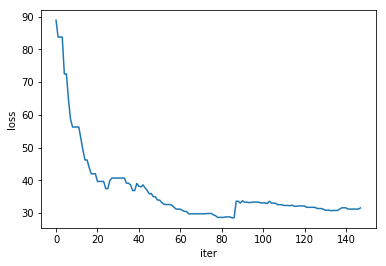

In [323]:
from matplotlib import pyplot as plt

plt.plot(loss)
plt.ylabel('loss')
plt.xlabel('iter')
plt.show()

# Network

In [101]:
class Module(object):
    def __init__ (self):
        self.output = None
        self.gradInput = None
        self.training = True
    
    def forward(self, input):
        return self.updateOutput(input)

    def backward(self,input, gradOutput):
        self.updateGradInput(input, gradOutput)
        self.accGradParameters(input, gradOutput)
        return self.gradInput
    

    def updateOutput(self, input):        
        pass

    def updateGradInput(self, input, gradOutput):
        pass   
    
    def accGradParameters(self, input, gradOutput):
        pass
    
    def zeroGradParameters(self): 
        pass
        
    def getParameters(self):
        return []
        
    def getGradParameters(self):
        return []
    
    def train(self):
        self.training = True
    
    def evaluate(self):
        self.training = False
    
    def __repr__(self):
        return "Module"

class Sequential(Module):
    def __init__ (self):
        super(Sequential, self).__init__()
        self.modules = []
   
    def add(self, module):
        self.modules.append(module)

    def updateOutput(self, input):
        self.output = [input]
        for module in self.modules:
            self.output.append(module.forward(self.output[-1]))
        return self.output[-1]
        #return self.output

    def backward(self, input, gradOutput):
        self.gradInput =  gradOutput   
        for i, module in enumerate(reversed(self.modules)):
            self.gradInput = module.backward(self.output[-i-2], self.gradInput)
        return self.gradInput
      

    def zeroGradParameters(self): 
        for module in self.modules:
            module.zeroGradParameters()
    
    def getParameters(self):
        return [x.getParameters() for x in self.modules]
    
    def getGradParameters(self):
        return [x.getGradParameters() for x in self.modules]
    
    def __repr__(self):
        string = "".join([str(x) + '\n' for x in self.modules])
        return string
    
    def __getitem__(self,x):
        return self.modules.__getitem__(x)
    
    def train(self):
        self.training = True
        for module in self.modules:
            module.train()
    
    def evaluate(self):
        self.training = False
        for module in self.modules:
            module.evaluate()
            
class Linear(Module):
    def __init__(self, n_in, n_out):
        super(Linear, self).__init__()
       
        stdv = 1./np.sqrt(n_in)
        self.W = np.random.uniform(-stdv, stdv, size = (n_out, n_in))
        self.b = np.random.uniform(-stdv, stdv, size = n_out)
        
        self.gradW = np.zeros_like(self.W)
        self.gradb = np.zeros_like(self.b)
        
    def updateOutput(self, input):
        self.output = #input @ self.W.T + self.b
        return self.output
    
    def updateGradInput(self, input, gradOutput):
        self.gradInput = gradOutput @ self.W
        return self.gradInput
    
    def accGradParameters(self, input, gradOutput):
        self.gradW = gradOutput.T @ input
        self.gradb = np.sum(gradOutput, axis = 0)
        pass
    
    def zeroGradParameters(self):
        self.gradW.fill(0)
        self.gradb.fill(0)
        
    def getParameters(self):
        return [self.W, self.b]
    
    def getGradParameters(self):
        return [self.gradW, self.gradb]
    
    def __repr__(self):
        s = self.W.shape
        q = 'Linear %d -> %d' %(s[1],s[0])
        return q

# Criterion

In [75]:
class Criterion(object):
    def __init__ (self):
        self.output = None
        self.gradInput = None
        
    def forward(self, input, target):
        return self.updateOutput(input, target)

    def backward(self, input, target):
        return self.updateGradInput(input, target)
    
    def updateOutput(self, input, target):
        return self.output

    def updateGradInput(self, input, target):
        return self.gradInput   

    def __repr__(self):
        return "Criterion"
    
# class ClassNLLCriterionUnstable(Criterion):
#     EPS = 1e-15
#     def __init__(self):
#         a = super(ClassNLLCriterionUnstable, self)
#         super(ClassNLLCriterionUnstable, self).__init__()
        
#     def updateOutput(self, input, target):         
#         input_clamp = np.clip(input, self.EPS, 1 - self.EPS)
#         self.output = -1/input.shape[0] * np.sum(target * np.log(input_clamp))
#         return self.output

#     def updateGradInput(self, input, target):
#         input_clamp = np.clip(input, self.EPS, 1 - self.EPS)
#         self.gradInput = -target/(input.shape[0] * input_clamp)
#         return self.gradInput
    
#     def __repr__(self):
#         return "ClassNLLCriterionUnstable"
    
class ClassNLLCriterion(Criterion):
    def __init__(self):
        a = super(ClassNLLCriterion, self)
        super(ClassNLLCriterion, self).__init__()
        
    def updateOutput(self, input, target): 
        self.output = -1/input.shape[0] * np.sum(target * input)
        return self.output

    def updateGradInput(self, input, target):
        self.gradInput = -target/input.shape[0]
        return self.gradInput
    
    def __repr__(self):
        return "ClassNLLCriterion"

## [Adam](https://arxiv.org/pdf/1412.6980.pdf) optimizer
- `variables` - list of lists of variables (one list per layer)
- `gradients` - list of lists of current gradients (same structure as for `variables`, one array for each var)
- `config` - dict with optimization parameters (`learning_rate`, `beta1`, `beta2`, `epsilon`)
- `state` - dict with optimizator state (used to save 1st and 2nd moment for vars)

Formulas for optimizer:

Current step learning rate: $$\text{lr}_t = \text{learning_rate} * \frac{\sqrt{1-\beta_2^t}} {1-\beta_1^t}$$
First moment of var: $$\mu_t = \beta_1 * \mu_{t-1} + (1 - \beta_1)*g$$ 
Second moment of var: $$v_t = \beta_2 * v_{t-1} + (1 - \beta_2)*g*g$$
New values of var: $$\text{variable} = \text{variable} - \text{lr}_t * \frac{m_t}{\sqrt{v_t} + \epsilon}$$

In [71]:
def adam_optimizer(variables, gradients, config, state):  
    # 'variables' and 'gradients' have complex structure, accumulated_grads will be stored in a simpler one
    state.setdefault('m', {})  # first moment vars
    state.setdefault('v', {})  # second moment vars
    state.setdefault('t', 0)   # timestamp
    state['t'] += 1
    for k in ['learning_rate', 'beta1', 'beta2', 'epsilon']:
        assert k in config, config.keys()
    
    var_index = 0 
    lr_t = config['learning_rate'] * np.sqrt(1 - config['beta2']**state['t']) / (1 - config['beta1']**state['t'])
    for current_layer_vars, current_layer_grads in zip(variables, gradients): 
        for current_var, current_grad in zip(current_layer_vars, current_layer_grads):
            var_first_moment = state['m'].setdefault(var_index, np.zeros_like(current_grad))
            var_second_moment = state['v'].setdefault(var_index, np.zeros_like(current_grad))

            np.add(var_first_moment * config['beta1'], (1 - config['beta1']) * current_grad, out=var_first_moment)
            np.add(var_second_moment * config['beta2'], (1 - config['beta2']) * current_grad * current_grad, out=var_second_moment)
            current_var -= lr_t * var_first_moment / (np.sqrt(var_second_moment) + config['epsilon'])
                        
            # small checks that you've updated the state; use np.add for rewriting np.arrays values
            assert var_first_moment is state['m'].get(var_index)
            assert var_second_moment is state['v'].get(var_index)
            var_index += 1


In [ ]:
len_ = 3 # n layers

weights = Sequential()
for i in range(len_):
    weights.add(Linear(n_in=len(features), n_out=len(features)))
#net.add(BatchNormalization(alpha=0.5))
#net.add(ChannelwiseScaling(n_out=50))
#net.add(ReLU())
#net.add(Linear(n_in=50, n_out=10))
#net.add(LogSoftMax())

#weights = Linear(len(features), len_)

In [ ]:
n_epoch = 10

for epoch in range(n_epoch):
    weights.zeroGradParameters()
    
    # те какие-то манипуляции с текстами
    indx = np.random.randint(0, X.shape[0])
    x_true, y_true, x_wrong = get_element(weights.getParameters()[0], indx):
        
    #loss = criterion(input1, input2, target)
    
    #weights.backward(x_batch, criterion.backward(y_pred, y_batch))
    
    adam_optimizer(weights.getParameters(), 
                     weights.getGradParameters(), 
                     config = {'learning_rate': 0.01, 'beta1': 0.9, 'beta2': 0.9, 'epsilon': 10e-9},
                     state = {})   
    
    # assert контролируем nneg

In [ ]:
#  -----------------------------------------------------------------------------------------------

In [ ]:
def train():
    weights.train()
    train_acc_ = 0.
    loss_train_ = 0.
    if i == 30:
        lr /= 10.
    for x_batch, y_batch in get_batches((X_train, y_train), batch_size):        
        weights.zeroGradParameters()
        y_pred = weights.forward(x_batch)
        loss = criterion.forward(y_pred, y_batch)
        train_acc += accuracy(y_pred, y_batch)
        loss_train += loss       
        weights.backward(x_batch, criterion.backward(y_pred, y_batch))
        adam_optimizer(weights.getParameters(), 
                     weights.getGradParameters(), 
                     config = {'learning_rate': 0.01, 'beta1': 0.9, 'beta2': 0.9, 'epsilon': 10e-9},
                     state = {})   
    acc_train_ /= len(y_train) / batch_size
    return train_acc_, loss_train_

In [67]:
import torch
from torch.nn.modules.loss import MarginRankingLoss
from torch.optim import Adagrad

weights = [torch.tensor(i).float() for i in weights]
sgd_learning_rate = 0.1
momentum = 0.9

criterization = MarginRankingLoss()
optimizer =  Adagrad(weights, sgd_learning_rate)

In [69]:
def adagrad_update_numpy(param, accum, g_t, lr=0.001, epsilon=1e-7):
      accum_t = accum + g_t * g_t
      param_t = param - lr * g_t / (np.sqrt(accum_t) + epsilon)
      return param_t, accum_t
    
def sparse_adagrad_update_numpy(param,
                                accum,
                                gindexs,
                                gvalues,
                                lr=0.001,
                                epsilon=1e-7):
      accum_t = copy.deepcopy(accum)
      param_t = copy.deepcopy(param)
      # first loop accumulates repeated indices if necessary.
      for i in range(len(gindexs)):
        gindex = gindexs[i]
        gvalue = gvalues[i]
        accum_t[gindex] = accum_t[gindex] + gvalue * gvalue
      for i in range(len(gindexs)):
        gindex = gindexs[i]
        gvalue = gvalues[i]
        param_t[gindex] = param_t[gindex] - lr * gvalue / (
            np.sqrt(accum_t[gindex]) + epsilon)
      return param_t, accum_t

In [ ]:
n_epoch = 10

for epoch in range(n_epoch):
    optimizer.zero_grad()
    
    # те какие-то манипуляции с текстами
    
    loss = criterization(input1, input2, target)
    
    loss.backward()
    optimizer.step()
    
    # assert l2 == 1 and l2 < числа

In [58]:
from torch.nn import Module

from torch import functional as F
from torch import _reduction as _Reduction
from torch._jit_internal import weak_module, weak_script_method

def margin_ranking_loss(input1, input2, target, margin=0, size_average=None,
                        reduce=None, reduction='mean'):
    # type: (Tensor, Tensor, Tensor, float, Optional[bool], Optional[bool], str) -> Tensor
    r"""margin_ranking_loss(input1, input2, target, margin=0, size_average=None, reduce=None, reduction='mean') -> Tensor
    See :class:`~torch.nn.MarginRankingLoss` for details.
    """  # noqa
    if size_average is not None or reduce is not None:
        reduction_enum = _Reduction.legacy_get_enum(size_average, reduce)
    else:
        reduction_enum = _Reduction.get_enum(reduction)
    if input1.dim() == 0 or input2.dim() == 0 or target.dim() == 0:
        raise RuntimeError(("margin_ranking_loss does not support scalars, got sizes: "
                            "input1: {}, input2: {}, target: {} ".format(input1.size(), input2.size(), target.size())))
    return torch.margin_ranking_loss(input1, input2, target, margin, reduction_enum)

class _Loss(Module):
    def __init__(self, size_average=None, reduce=None, reduction='mean'):
        super(_Loss, self).__init__()
        if size_average is not None or reduce is not None:
            self.reduction = _Reduction.legacy_get_string(size_average, reduce)
        else:
            self.reduction = reduction
            
class MarginRankingLoss(_Loss):
    __constants__ = ['margin', 'reduction']

    def __init__(self, margin=0., size_average=None, reduce=None, reduction='mean'):
        super(MarginRankingLoss, self).__init__(size_average, reduce, reduction)
        self.margin = margin

    @weak_script_method
    def forward(self, input1, input2, target):
        return F.margin_ranking_loss(input1, input2, target, margin=self.margin, reduction=self.reduction)

ImportError: cannot import name '_reduction'

In [59]:
class Optimizer:
    """The base class for optimizers.

    All optimizers must implement a step() method that updates the parameters.
    The general optimization loop then looks like this:

    for inputs, targets in dataset:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()

    `zero_grad` initializes the gradients of the parameters to zero. This
    allows to accumulate gradients (instead of replacing it) during
    backpropagation, which is e.g. useful for skip connections.
    """

    def __init__(self, params: Iterable[Parameter]):
        """
        Args:
            params: The parameters to be optimized.
        """
        self._params = params

    def step(self) -> None:
        """Update the parameters."""
        raise NotImplementedError

    def zero_grad(self) -> None:
        """Clear the gradients of all optimized parameters."""
        for param in self._params:
            assert isinstance(param, Parameter)
            param.grad = np.zeros_like(param.data)


class SGD(Optimizer):
    """Stochastic Gradient Descent (SGD) optimizer with optional Momentum."""

    def __init__(self, params: Iterable[Parameter], lr: float,
                 momentum: Optional[float] = None):
        super().__init__(params)
        self.lr = lr
        self.momentum = momentum
        if momentum:
            for param in self._params:
                param.state_dict["momentum"] = np.zeros_like(param.data)

    def step(self):
        for p in self._params:
            if self.momentum:
                # update the momentum
                p.state_dict["momentum"] *= self.momentum
                p.state_dict["momentum"] -= self.lr * p.grad
                # update the parameter
                p.data += p.state_dict["momentum"]
            else:
                p.data -= self.lr * p.grad

NameError: name 'Iterable' is not defined